In [1]:
import numpy as np 
import copy 
import random
import time
from math import sqrt, inf, log
import pickle as pkl
random.seed(1)

In [2]:
#new 
row = 6
col = 5
player0 = -1
player1 = 1
game_draw = 0
game_not_over=10

def game_result(state):
      
        for j in range (col):
            for i in range(row-3):
                if state[i][j] == state[i+1][j] == state[i+2][j] == state[i+3][j] == player0:
                    return player0
                elif state[i][j] == state[i+1][j] == state[i+2][j] == state[i+3][j] == player1:
                    return player1
                    
        for i in range (row):
            for j in range(col-3):
                if state[i][j] == state[i][j+1] == state[i][j+2] == state[i][j+3] == player0:
                    return player0
                elif state[i][j] == state[i][j+1] == state[i][j+2] == state[i][j+3] == player1:
                    return player1
            
        for i in range (row-3):
            for j in range(col-3):
                if state[i][j]==state[i+1][j+1] ==state[i+2][j+2]==state[i+3][j+3] == player0:
                    return player0
                elif state[i][j]==state[i+1][j+1] ==state[i+2][j+2] ==state[i+3][j+3] == player1:
                    return player1
                
        for i in range (3,row):
            for j in range(col-3):
                if state[i][j]==state[i-1][j+1] ==state[i-2][j+2] ==state[i-3][j+3] == player0:
                    return player0
                elif state[i][j]==state[i-1][j+1] == state[i-2][j+2] ==state[i-3][j+3] == player1:
                    return player1
                
        drawn=True
        for i in range (row):
            for j in range (col):
                if state[i][j]==0:
                    drawn = False
                    break
            if not drawn:
                break
                    
                        
        if drawn:
            return game_draw
        else:
            return game_not_over
            

In [3]:
class Node:
    def __init__(self, player, state, parent):
        self.player= player #in the current state, this player is about to make the move and transition to the next state
        self.visited_count=0
        self.reward=0
        self.state=state
        self.parent=parent
        self.children=[]
        
    def update_with_win(self):
        self.visited_count+=1
        self.reward+=1
        
    def update_with_loss(self):
        self.visited_count+=1
        
    def update_with_draw(self):
        self.visited_count+=1
        self.reward+=0.5
        

In [4]:
class MonteCarloTreeSearch:
    #TODO: when player 2 is mcts, initialize root with -1 
    def expand(self,curr_node):       
        child_states=[]
        for j in range(col):
            for i in reversed(range(row)):
                new_state = copy.deepcopy(curr_node.state)
                if new_state[i][j] == 0:
                    new_state[i][j] = curr_node.player*-1
                    curr_node.children.append(Node(curr_node.player*-1, new_state, curr_node))
                    break
            
        if len(curr_node.children) == 0:
            return  None
        return random.choice(curr_node.children)
        
    
    def uct_action_selection(self, node,c=sqrt(2)):
        if node.visited_count == 0: 
            return inf
        else:
            return (node.reward/node.visited_count) + (c * sqrt(log(node.parent.visited_count)/node.visited_count))
    
    
    def select(self, curr_node):    
        while len(curr_node.children) != 0:
            uct_action_values=[self.uct_action_selection(child_node) for child_node in curr_node.children]
            curr_node=curr_node.children[np.argmax(uct_action_values)]
            
        return curr_node          
    
  
    def simulate(self,curr_node):
        sim_node=copy.deepcopy(curr_node)
        
        while game_result(sim_node.state)==game_not_over:
            next_states=[]
            for j in range (col):
                for i in reversed(range (row)):
                    if sim_node.state[i][j]==0:
                        next_states.append([i,j])
                        break
                        
            next_state=random.choice(next_states)
            sim_node.state[next_state[0]][next_state[1]] = sim_node.player*-1
            sim_node.player = sim_node.player * -1
        #print ("Sim result:", game_result(sim_node))
        return game_result(sim_node.state) 
    
    def back_propagate(self, curr_node, game_res):
        while curr_node != None:
            if curr_node.player==game_res:
                curr_node.update_with_win()
            elif game_res == game_draw:
                curr_node.update_with_draw()
            elif curr_node.player * -1 == game_res:
                curr_node.update_with_loss()
                
            curr_node = curr_node.parent
            
            
            
    def search(self, root,num_sims=200):
        for i in range(num_sims):
            
            leaf = self.select(root) 
            
            leaf_result = game_result (leaf.state)
            if leaf_result != game_not_over:
                self.back_propagate(leaf,leaf_result)
                continue
                
            new_node= self.expand(leaf)
            
            if new_node:
                new_node_result = game_result(new_node.state)
                if new_node_result != game_not_over:
                    self.back_propagate(new_node,new_node_result)
                    continue
                
                res = self.simulate(new_node)
                self.back_propagate(new_node, res)
        
        return root.children[np.argmax([i.visited_count for i in root.children])]

# MCTS vs Human player

In [571]:
root_state = np.zeros((row,col), dtype=int)
mctsObj = MonteCarloTreeSearch()
root_node = Node(1, root_state, None)
while game_result(root_node.state)==game_not_over:
    call_count = 0 
    new_state = mctsObj.search(root_node)
    print (new_state.state)
    if game_result(new_state.state)!=game_not_over:
        print ("Player 1 wins")
        break
    j = int(input())
    j = j-1
    for i in reversed(range(row)):
        if new_state.state[i][j] == 0:
            new_state.state[i][j] = 1
            break
            
    root_node = Node(1,new_state.state, None)
    
    print (root_node.state)
    print ("Move done\n")
    
if (game_result(new_state.state)==player1):
    print("Player 2 wins!")
elif (game_result(new_state.state)==game_draw):
    print  ("Draw")

Visited count for rootNode: 200
Visited count for the selected node: 59
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]]
2
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 62
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0  0 -1]]
2
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [-1  1  0  0 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [-1  1  0  0 -1]]
3
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [-1  1  1  0 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 48
[[ 0  0  0  0  0]
 

# MCTS 200 vs MCTS  40

In [575]:

player1count=0
player2count=0
drawcount=0
for i in range(50):
    root_state = np.zeros((row,col), dtype=int)
    mctsObj = MonteCarloTreeSearch()
    root_node = Node(1, root_state, None)
    while game_result(root_node.state)==game_not_over:

        new_state = mctsObj.search(root_node)
        print (new_state.state)
        if game_result(new_state.state)!=game_not_over:
            print ("Player 1 wins")
            player1count+=1
            break

        root_node = Node(-1,new_state.state, None)
        new_state= mctsObj.search(root_node, num_sims=40)
        print (new_state.state)
        root_node = Node(1,new_state.state, None)
        print ("Move done\n")

    if (game_result(new_state.state)==player1):
        print("Player 2 wins!")
        player2count+=1
    elif (game_result(new_state.state)==game_draw):
        print  ("Draw")
        drawcount+=1
        
print (player1count)
print(player2count)
print(drawcount)

Visited count for rootNode: 200
Visited count for the selected node: 58
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  0 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 65
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 1 -1  0  1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 187
[[ 0 -1 -1  0 -1]
 [ 0  1 -1  0  1]
 [ 0 -1  1  0 -1]
 [ 0  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 27
[[ 0 -1 -1  0 -1]
 [ 0  1 -1  0  1]
 [ 0 -1  1  0 -1]
 [ 1  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 187
[[ 0 -1 -1  0 -1]
 [ 0  1 -1  0  1]
 [-1 -1  1  0 -1]
 [ 1  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 20
[[ 0 -1 -1  0 -1]
 [ 1  1 -1  0  1]
 [-1 -1  1  0 -1]
 [ 1  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 188
[[-1 -1 -1  0 -1]
 [ 1  1 -1  0  1]
 [-1 -1  1  0 -1]
 [ 1  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 40
[

Visited count for rootNode: 200
Visited count for the selected node: 49
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  1  0  0]
 [ 0 -1 -1 -1  0]
 [ 0  1 -1  1  0]
 [-1  1  1  1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 8
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  1  0  0]
 [ 0 -1 -1 -1  0]
 [ 1  1 -1  1  0]
 [-1  1  1  1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 50
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  1  0  0]
 [-1 -1 -1 -1  0]
 [ 1  1 -1  1  0]
 [-1  1  1  1 -1]]
Player 1 wins
Visited count for rootNode: 200
Visited count for the selected node: 61
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 78
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]
 [ 0  0  1 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]
 [ 0  0  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]
 [ 0  0  1 -1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0  0 -1 -1  0]
 [ 0  0  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 50
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  1  0  0]
 [ 0 -1  1  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 72
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]
 [ 0 -1  1  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]
 [ 1 -1  1  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 74
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]
 [ 1 -1  1  0  0]]
Player 1 wins
Visited count for rootNode: 200
Visited count for the selecte

Visited count for rootNode: 200
Visited count for the selected node: 54
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]
 [ 0  1  0  1 -1]
 [-1  1  0 -1 -1]
 [-1 -1  0  1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1  0  1  0]
 [ 0  1  0  1 -1]
 [-1  1  0 -1 -1]
 [-1 -1  0  1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 55
[[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1  0  1  0]
 [-1  1  0  1 -1]
 [-1  1  0 -1 -1]
 [-1 -1  0  1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 15
[[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 1 -1  0  1  0]
 [-1  1  0  1 -1]
 [-1  1  0 -1 -1]
 [-1 -1  0  1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 75
[[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 1 -1  0  1 -1]
 [-1  1  0  1 -1]
 [-1  1  0 -1 -1]
 [-1 -1  0  1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 16
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 53
[[ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 1  0  0  1  0]
 [-1  0  0 -1  1]
 [-1 -1  0  1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 1  0  0  1  1]
 [-1  0  0 -1  1]
 [-1 -1  0  1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 61
[[ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [-1  0  0  1  0]
 [ 1  0  0  1  1]
 [-1  0  0 -1  1]
 [-1 -1  0  1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [-1  0  0  1  0]
 [ 1  0  0  1  1]
 [-1  0  0 -1  1]
 [-1 -1  1  1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 69
[[ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [-1  0  0  1  0]
 [ 1  0  0  1  1]
 [-1 -1  0 -1  1]
 [-1 -1  1  1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 47
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 47
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1 -1  0  1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [-1 -1  0  1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [-1 -1  0  1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 87
[[ 0  1 -1  0  0]
 [ 0 -1  1 -1  0]
 [ 0  1 -1  1  0]
 [-1  1 -1  1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  1 -1  0  0]
 [ 0 -1  1 -1  0]
 [ 1  1 -1  1  0]
 [-1  1 -1  1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1  1 -1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 77
[[ 0  1 -1  0  0]
 [ 0 -1  1 -1  0]
 [ 1  1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 15
[[ 0  1 -1  0  0]
 [ 0 -1  1 -1  1]
 [ 1  1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1  1 -1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 67
[[ 0  1 -1  0  0]
 [-1 -1  1 -1  1]
 [ 1  1 -1  1 -1]
 [-1  1 -1  1 -1]
 [ 1  1 -1 -1  1]
 [-1 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 1

Visited count for rootNode: 200
Visited count for the selected node: 54
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 9
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 73
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]
 [ 1 -1  0  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1 -1 -1]]
Player 1 wins
Visited count for rootNode: 200
Visited count for the selected node: 52
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 96
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0  1 -1  0]
 [ 0 -1  1  1  0]
 [ 0 -1  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  1  0]
 [ 0  0  1 -1  0]
 [ 0 -1  1  1  0]
 [ 0 -1  1 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 65
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  1  0]
 [ 0  0  1 -1  0]
 [ 0 -1  1  1  0]
 [ 0 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0 -1  1  0]
 [ 0  0  1 -1  0]
 [ 0 -1  1  1  0]
 [ 0 -1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 57
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0 -1  1  0]
 [ 0 -1  1 -1  0]
 [ 0 -1  1  1  0]
 [ 0 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 57
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 67
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [-1  0  0 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [-1  0  1 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 62
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  1  0]
 [-1  0  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 66
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  0]
 [-1  1 -1  0  1]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  1]
 [-1  1 -1  0  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 75
[[ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  1]
 [-1  1 -1  0  1]]
Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  0  1  0  0]
 [ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  1]
 [-1  1 -1  0  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 75
[[ 0  0  1  0  0]
 [ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  1]
 [-1  1 -1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 51
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 66
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 80
[[ 0  1  0  1  0]
 [ 1 -1  0  1 -1]
 [-1 -1  0 -1  1]
 [ 1  1 -1 -1 -1]
 [ 1  1 -1  1 -1]
 [-1 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 30
[[ 0  1  0  1  0]
 [ 1 -1  0  1 -1]
 [-1 -1  1 -1  1]
 [ 1  1 -1 -1 -1]
 [ 1  1 -1  1 -1]
 [-1 -1  1 -1  1]]
Move done

Player 2 wins!
Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 51
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]
 [ 1 -1  0  0  0]]
Visited count for rootNode: 40
Visited count for the selecte

Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1 -1  0  1]
 [-1 -1  1  0 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1 -1  0  1]
 [-1 -1  1  0 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 72
[[ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1 -1  0  1]
 [-1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1 -1  1  1]
 [-1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 67
[[ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1 -1  0  0]
 [ 0 -1  1 -1  0]
 [ 0  1 -1  1  1]
 [-1 -1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 108
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  0  0  0]
 [ 1 -1  0  1  0]
 [-1 -1  0  1  1]]
Player 1 wins
Visited count for rootNode: 200
Visited count for the selected node: 48
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1  0  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1 -1  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 -1 -1  1  0]]
Move done

Visited count for rootNode: 200
Visited count for the select

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0 -1  0  0]
 [ 1  0 -1  0  0]
 [ 1  0  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [-1  0 -1  0  0]
 [ 1  0 -1  0  0]
 [ 1  0  1 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 45
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [-1  0 -1  0  0]
 [ 1  0 -1  0  0]
 [ 1 -1  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [-1  0 -1  0  0]
 [ 1  0 -1  1  0]
 [ 1 -1  1 -1  0]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 66
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [-1  0 -1 -1  0]
 [ 1  0 -1  1  0]
 [ 1 -1  1 -1  0]]
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 67
[[ 0  0 -1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1 -1  0]
 [-1  0 -1  1  0]
 [-1  1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 16
[[ 0  0 -1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1 -1  0]
 [-1  1 -1  1  0]
 [-1  1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 73
[[ 0  0 -1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1 -1  0]
 [ 0  0  1 -1  0]
 [-1  1 -1  1  0]
 [-1  1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0 -1  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1 -1  0]
 [ 1  0  1 -1  0]
 [-1  1 -1  1  0]
 [-1  1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 76
[[ 0  0 -1  0  0]
 [ 0  0  1 -1  0]
 [ 0  0  1 -1  0]
 [ 1  0  1 -1  0]
 [-1  1 -1  1  0]
 [-1  1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 18
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 71
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1 -1  0]
 [ 0 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1 -1  0]
 [ 0 -1  1 -1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  1  0  0]
 [ 0 -1 -1 -1  0]
 [ 0 -1  1 -1  1]]
Visited count for rootNode: 40
Visited count for the selected node: 9
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1  1  0  0]
 [ 0 -1 -1 -1  0]
 [ 0 -1  1 -1  1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 88
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  1  1  0  0]
 [ 0 -1 -1 -1 -1]
 [ 0 -1  1 -1  1]]
Player 1 wins
Visited count for rootNode: 200
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 200
[[ 1  1  0 -1  1]
 [-1  1  0 -1  1]
 [-1  1  0  1 -1]
 [ 1 -1  0 -1  1]
 [ 1  1  0 -1 -1]
 [-1  1 -1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 40
[[ 1  1  0 -1  1]
 [-1  1  0 -1  1]
 [-1  1  0  1 -1]
 [ 1 -1  0 -1  1]
 [ 1  1  1 -1 -1]
 [-1  1 -1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 200
[[ 1  1  0 -1  1]
 [-1  1  0 -1  1]
 [-1  1  0  1 -1]
 [ 1 -1 -1 -1  1]
 [ 1  1  1 -1 -1]
 [-1  1 -1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 40
[[ 1  1  0 -1  1]
 [-1  1  0 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1 -1 -1  1]
 [ 1  1  1 -1 -1]
 [-1  1 -1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 200
[[ 1  1  0 -1  1]
 [-1  1 -1 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1 -1 -1  1]
 [ 1  1  1 -1 -1]
 [-1  1 -1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 40
[

Visited count for rootNode: 40
Visited count for the selected node: 40
[[ 0 -1 -1 -1  1]
 [ 0  1  1  1 -1]
 [ 1 -1 -1  1  1]
 [-1 -1  1  1 -1]
 [ 1  1 -1 -1  1]
 [-1  1  1 -1 -1]]
Move done

Visited count for rootNode: 200
Visited count for the selected node: 200
[[ 0 -1 -1 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1 -1  1  1]
 [-1 -1  1  1 -1]
 [ 1  1 -1 -1  1]
 [-1  1  1 -1 -1]]
Visited count for rootNode: 40
Visited count for the selected node: 40
[[ 1 -1 -1 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1 -1  1  1]
 [-1 -1  1  1 -1]
 [ 1  1 -1 -1  1]
 [-1  1  1 -1 -1]]
Move done

Draw
Visited count for rootNode: 200
Visited count for the selected node: 54
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]]
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1 -1  0  0]]
Move done

Visited count for rootNode: 200
Visited count for the selec

# MCTS 40 vs MCTS  200

In [5]:

player1count=0
player2count=0
drawcount=0
for i in range(50):
    root_state = np.zeros((row,col), dtype=int)
    mctsObj = MonteCarloTreeSearch()
    root_node = Node(1, root_state, None)
    while game_result(root_node.state)==game_not_over:

        new_state = mctsObj.search(root_node, num_sims=40)
        print (new_state.state)
        if game_result(new_state.state)!=game_not_over:
            print ("Player 1 wins")
            player1count+=1
            break

        root_node = Node(-1,new_state.state, None)
        new_state= mctsObj.search(root_node)
        print (new_state.state)
        root_node = Node(1,new_state.state, None)
        print ("Move done\n")

    if (game_result(new_state.state)==player1):
        print("Player 2 wins!")
        player2count+=1
    elif (game_result(new_state.state)==game_draw):
        print  ("Draw")
        drawcount+=1
        
print (player1count)
print(player2count)
print(drawcount)

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 49
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1 -1  0  0  1]]
Visited count for rootNode: 200
Visited count for the selected node: 78
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1 -1  0  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]
 [-1 -1  0  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 66
[[ 0

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 51
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1 -1  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 15
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1 -1  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 64
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1 -1  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1 -1  0  0]
 [ 0  1 -1  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 49
[[ 0  1  0  0  0]
 [ 1  1  1  0  0]
 [-1 -1 -1  0 -1]
 [ 1  1 -1  0 -1]
 [-1 -1  1 -1  1]
 [-1 -1  1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  1 -1  0  0]
 [ 1  1  1  0  0]
 [-1 -1 -1  0 -1]
 [ 1  1 -1  0 -1]
 [-1 -1  1 -1  1]
 [-1 -1  1  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 91
[[ 1  1 -1  0  0]
 [ 1  1  1  0  0]
 [-1 -1 -1  0 -1]
 [ 1  1 -1  0 -1]
 [-1 -1  1 -1  1]
 [-1 -1  1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 23
[[ 1  1 -1  0  0]
 [ 1  1  1  0 -1]
 [-1 -1 -1  0 -1]
 [ 1  1 -1  0 -1]
 [-1 -1  1 -1  1]
 [-1 -1  1  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 180
[[ 1  1 -1  0  1]
 [ 1  1  1  0 -1]
 [-1 -1 -1  0 -1]
 [ 1  1 -1  0 -1]
 [-1 -1  1 -1  1]
 [-1 -1  1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected n

Visited count for rootNode: 200
Visited count for the selected node: 73
[[ 0  0  0  0  0]
 [ 0  0 -1  1  0]
 [ 1  0  1 -1  0]
 [-1  0  1  1  0]
 [ 1  0 -1 -1  0]
 [-1  0  1 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0 -1  0]
 [ 0  0 -1  1  0]
 [ 1  0  1 -1  0]
 [-1  0  1  1  0]
 [ 1  0 -1 -1  0]
 [-1  0  1 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0 -1  0]
 [ 1  0 -1  1  0]
 [ 1  0  1 -1  0]
 [-1  0  1  1  0]
 [ 1  0 -1 -1  0]
 [-1  0  1 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0 -1  0]
 [ 1  0 -1  1  0]
 [ 1  0  1 -1  0]
 [-1  0  1  1  0]
 [ 1  0 -1 -1  0]
 [-1 -1  1 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 78
[[ 1  0  0 -1  0]
 [ 1  0 -1  1  0]
 [ 1  0  1 -1  0]
 [-1  0  1  1  0]
 [ 1  0 -1 -1  0]
 [-1 -1  1 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 48
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 15
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  0 -1  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 68
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1  0  0]
 [ 0  0 -1  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1  0  0]
 [ 0 -1 -1  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 59
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1  0  0]
 [ 0 -1 -1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 54
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [-1 -1  0  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0 -1  0]
 [-1 -1  0  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 57
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0 -1  0]
 [-1 -1  0  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0 -1 -1]
 [-1 -1  0  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 73
[[ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [ 0  1  0 -1 -1]
 [-1 -1  0  1 -1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for 

Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0  0  0 -1  0]
 [ 0  1  1  1  1]
 [ 0 -1  1 -1 -1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for the selected node: 9
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0 -1]
 [ 0 -1  0  0  1]]
Visited count for rootNode: 200
Visited count for the selected node: 47
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0 -1]
 [ 0 -1  1  0  1]]
Move done

Visited count for rootNode: 40
Visited count for t

Visited count for rootNode: 200
Visited count for the selected node: 61
[[ 0 -1  0  0  0]
 [ 0  1  0 -1  1]
 [ 1 -1  0 -1  1]
 [-1 -1  0  1  1]
 [-1  1  0  1  1]
 [-1  1  0 -1 -1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for the selected node: 16
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 48
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  0  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]
 [ 0 -1  0  1  0]]
Move done

Visited count for rootNode: 40
Visited count for 

Visited count for rootNode: 200
Visited count for the selected node: 78
[[ 0 -1  0 -1  0]
 [ 0 -1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1  1  0  1  1]
 [ 1 -1  0 -1  1]
 [-1  1  1 -1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 18
[[ 0 -1  0 -1  0]
 [-1 -1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1  1  0  1  1]
 [ 1 -1  0 -1  1]
 [-1  1  1 -1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 80
[[ 0 -1  0 -1  0]
 [-1 -1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1  1  0  1  1]
 [ 1 -1  1 -1  1]
 [-1  1  1 -1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 30
[[ 0 -1  0 -1  0]
 [-1 -1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1  1 -1  1  1]
 [ 1 -1  1 -1  1]
 [-1  1  1 -1  1]]
Player 1 wins
Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 68
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 58
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1 -1  0  0  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 66
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1 -1  0  1  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 58
[[ 0  0  0  1  0]
 [ 0  1  0 -1  0]
 [ 0  1  0 -1  0]
 [-1 -1  0  1  0]
 [ 1  1  0 -1  0]
 [-1 -1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  1  0]
 [ 0  1  0 -1  0]
 [ 0  1  0 -1  0]
 [-1 -1  0  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1  1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 79
[[ 0  0  0  1  0]
 [ 0  1  0 -1  0]
 [ 0  1  0 -1  0]
 [-1 -1  0  1  0]
 [ 1  1 -1 -1  1]
 [-1 -1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 15
[[ 0  0  0  1  0]
 [ 0  1  0 -1  0]
 [-1  1  0 -1  0]
 [-1 -1  0  1  0]
 [ 1  1 -1 -1  1]
 [-1 -1  1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 68
[[ 0  0  0  1  0]
 [ 1  1  0 -1  0]
 [-1  1  0 -1  0]
 [-1 -1  0  1  0]
 [ 1  1 -1 -1  1]
 [-1 -1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 52
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0 -1 -1  0]
 [ 1 -1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 0 -1 -1 -1  0]
 [ 1 -1  1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 46
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 1 -1 -1 -1  0]
 [ 1 -1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  0  0]
 [ 1 -1 -1 -1 -1]
 [ 1 -1  1  1 -1]]
Player 1 wins
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 63
[[ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  0]
 [ 1 -1  0  1  0]
 [-1 -1  0  1 -1]
 [-1  1  1 -1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 16
[[ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  0]
 [ 1 -1  0  1 -1]
 [-1 -1  0  1 -1]
 [-1  1  1 -1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 125
[[ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1 -1  0  1 -1]
 [-1  1  1 -1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  1]
 [ 1 -1  0  1 -1]
 [-1 -1 -1  1 -1]
 [-1  1  1 -1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 167
[[ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0  1  0 -1  1]
 [ 1 -1  1  1 -1]
 [-1 -1 -1  1 -1]
 [-1  1  1 -1  1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count fo

Visited count for rootNode: 200
Visited count for the selected node: 147
[[ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [ 1  1  1  0  0]
 [-1 -1  1  0  0]
 [ 1  1 -1  0  0]
 [-1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [ 1  1  1  0  0]
 [-1 -1  1  0  0]
 [ 1  1 -1 -1  0]
 [-1 -1  1 -1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 74
[[ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [ 1  1  1  0  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0 -1  0  0  0]
 [ 0  1  0  0  0]
 [ 1  1  1 -1  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1  1 -1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 65
[[ 0 -1  0  0  0]
 [ 0  1  1  0  0]
 [ 1  1  1 -1  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1  1 -1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected n

Visited count for rootNode: 200
Visited count for the selected node: 52
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0 -1  0  1  0]
 [ 0  1  0  1  0]
 [ 0 -1  0 -1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0 -1  0  1  0]
 [ 0  1  0  1  0]
 [ 0 -1  0 -1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 92
[[ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0 -1  0  1  0]
 [ 0  1  0  1  0]
 [ 1 -1  0 -1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0 -1  0  1  0]
 [-1  1  0  1  0]
 [ 1 -1  0 -1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 58
[[ 0  0  0 -1  0]
 [ 0  0  0  1  0]
 [ 0 -1  0  1  0]
 [-1  1  0  1  0]
 [ 1 -1  0 -1  0]
 [-1  1  0 -1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 51
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0 -1  0]
 [ 0 -1  0  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 53
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]
 [ 0 -1  0  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 11
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0 -1  0]
 [ 0 -1 -1  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 70
[[ 0

Visited count for rootNode: 200
Visited count for the selected node: 53
[[ 0  0  0  0  0]
 [ 0 -1  0  0  1]
 [ 0 -1  0  1  1]
 [ 0  1  0 -1 -1]
 [ 1  1  1  1 -1]
 [-1  1 -1 -1 -1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 60
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 52
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for 

Visited count for rootNode: 200
Visited count for the selected node: 130
[[ 1 -1  1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  0  0]
 [ 1 -1 -1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 25
[[ 1 -1  1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  0  0]
 [ 1 -1 -1  0  0]
 [-1  1 -1  0 -1]
 [-1  1  1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 143
[[ 1 -1  1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  0  0]
 [ 1 -1 -1  0  1]
 [-1  1 -1  0 -1]
 [-1  1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 29
[[ 1 -1  1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  0 -1]
 [ 1 -1 -1  0  1]
 [-1  1 -1  0 -1]
 [-1  1  1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 101
[[ 1 -1  1  0  0]
 [-1  1 -1  0  0]
 [-1  1  1  0 -1]
 [ 1 -1 -1  0  1]
 [-1  1 -1  1 -1]
 [-1  1  1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 137
[[ 1  1  0  0  0]
 [-1  1  1  0  0]
 [-1 -1  1  0  0]
 [-1 -1 -1  0  0]
 [ 1  1  1  0  0]
 [-1 -1  1  0 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 17
[[ 1  1  0  0  0]
 [-1  1  1  0  0]
 [-1 -1  1  0  0]
 [-1 -1 -1  0  0]
 [ 1  1  1  0 -1]
 [-1 -1  1  0 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 133
[[ 1  1  1  0  0]
 [-1  1  1  0  0]
 [-1 -1  1  0  0]
 [-1 -1 -1  0  0]
 [ 1  1  1  0 -1]
 [-1 -1  1  0 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 26
[[ 1  1  1  0  0]
 [-1  1  1  0  0]
 [-1 -1  1  0  0]
 [-1 -1 -1  0 -1]
 [ 1  1  1  0 -1]
 [-1 -1  1  0 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 192
[[ 1  1  1  0  0]
 [-1  1  1  0  0]
 [-1 -1  1  0  1]
 [-1 -1 -1  0 -1]
 [ 1  1  1  0 -1]
 [-1 -1  1  0 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected

Visited count for rootNode: 200
Visited count for the selected node: 109
[[ 0  0  0  0  0]
 [-1  0  0  0  0]
 [ 1  0  0  0  0]
 [-1  0  1  0  0]
 [-1  1 -1  0  0]
 [-1  1 -1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 9
[[-1  0  0  0  0]
 [-1  0  0  0  0]
 [ 1  0  0  0  0]
 [-1  0  1  0  0]
 [-1  1 -1  0  0]
 [-1  1 -1  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 64
[[-1  0  0  0  0]
 [-1  0  0  0  0]
 [ 1  0  0  0  0]
 [-1  0  1  0  0]
 [-1  1 -1  0  1]
 [-1  1 -1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 12
[[-1  0  0  0  0]
 [-1  0  0  0  0]
 [ 1  0  0  0  0]
 [-1  0  1  0 -1]
 [-1  1 -1  0  1]
 [-1  1 -1  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 58
[[-1  0  0  0  0]
 [-1  0  0  0  0]
 [ 1  0  0  0  0]
 [-1  0  1  0 -1]
 [-1  1 -1  1  1]
 [-1  1 -1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 106
[[ 0 -1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1  1  0  1]
 [ 0  1 -1  0  1]
 [ 1 -1  1  1 -1]
 [-1 -1 -1  1 -1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 14
[[ 0 -1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 0  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1  1 -1]
 [-1 -1 -1  1 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 120
[[ 0 -1 -1  0  0]
 [ 0 -1  1  0  0]
 [ 1  1  1  0  1]
 [-1  1 -1  0  1]
 [ 1 -1  1  1 -1]
 [-1 -1 -1  1 -1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for the selected node: 13
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 47
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  1]]
Move done

Visited count for rootNode: 40
Visited count fo

Visited count for rootNode: 200
Visited count for the selected node: 58
[[ 0  0  0  0  0]
 [ 0  1  1  1  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1 -1  1  0]
 [-1 -1 -1  1  1]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  1  1  1  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1  1]]
Visited count for rootNode: 200
Visited count for the selected node: 68
[[ 0  0  0  0  0]
 [ 1  1  1  1  0]
 [-1 -1  1  1  0]
 [ 1  1 -1 -1  0]
 [-1 -1 -1  1 -1]
 [-1 -1 -1  1  1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0 -1]]
Visited count for rootNode: 200
Visited count for the selected node: 70
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0 -1]]
Move done

Visited count for rootNode: 40
Visited count for 

Visited count for rootNode: 200
Visited count for the selected node: 83
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 16
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0 -1  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 50
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0 -1  0 -1  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [-1 -1  0 -1  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 56
[[ 0  0  0  0  0]
 [ 0  1  0  1  0]
 [-1 -1  0 -1  0]
 [ 1  1  0 -1  0]
 [-1  1  0  1  0]
 [-1  1  0 -1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected no

Visited count for rootNode: 200
Visited count for the selected node: 44
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  1  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 9
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 75
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1  0  0  0]
 [ 0 -1  1  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 10
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0 -1 -1  0  0]
 [ 0 -1  1  0  0]]
Visited count for rootNode: 200
Visited count for the selected node: 86
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  1  0  0]
 [ 0 -1 -1  0  0]
 [ 0 -1  1  0  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected nod

Visited count for rootNode: 200
Visited count for the selected node: 49
[[ 0  0  0  0  0]
 [ 0 -1  0  1  0]
 [-1  1  0 -1  0]
 [ 1 -1  0  1  0]
 [-1  1  1  1  0]
 [-1 -1 -1  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 9
[[ 0  0  0  0  0]
 [-1 -1  0  1  0]
 [-1  1  0 -1  0]
 [ 1 -1  0  1  0]
 [-1  1  1  1  0]
 [-1 -1 -1  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 43
[[ 0  0  0  0  0]
 [-1 -1  0  1  0]
 [-1  1  0 -1  0]
 [ 1 -1  1  1  0]
 [-1  1  1  1  0]
 [-1 -1 -1  1  0]]
Move done

Visited count for rootNode: 40
Visited count for the selected node: 8
[[-1  0  0  0  0]
 [-1 -1  0  1  0]
 [-1  1  0 -1  0]
 [ 1 -1  1  1  0]
 [-1  1  1  1  0]
 [-1 -1 -1  1  0]]
Visited count for rootNode: 200
Visited count for the selected node: 52
[[-1  0  0  0  0]
 [-1 -1  0  1  0]
 [-1  1  0 -1  0]
 [ 1 -1  1  1  0]
 [-1  1  1  1  0]
 [-1 -1 -1  1  1]]
Move done

Player 2 wins!
Visited count for rootNode: 40
Visited count for th

# Q learning 

In [5]:
player0 = -1
player1 = 1
game_draw = 0
game_not_over=10
row = 4
col = 5

In [6]:
#TODO: Learning rate decay ?
class QLearning: 
    
    def __init__(self):
        self.q_values = {}
        
    def init_q_values(self,state):
        if self.q_values.get(np.array_str(state)) is None: 
            self.q_values[np.array_str(state)] = np.random.uniform(-1, 1, col)
            for j in range(col):
                if state[0][j] != 0:
                    self.q_values[np.array_str(state)][j] = -np.inf
        
            
    def learn(self, current_state, next_state,action_index, alpha = 0.1, gamma = 0.9, player = player1):
        #check here if next state is a terminal state and give rewards accordingly - what if there is no next state?
        self.init_q_values(current_state)
        self.init_q_values(next_state)
        
        rewards = 0 #if game is not over 
        
        if game_result(next_state) == player: 
            rewards = 100
        elif game_result(next_state) == player * -1:
            rewards = -100
        elif game_result (next_state) == game_draw:
            rewards = 0
            
        max_a= np.max(self.q_values[np.array_str(next_state)])
        
        if max_a == -np.Inf:
            max_a=-1000
        
        self.q_values[np.array_str(current_state)][action_index] += alpha *  (rewards + gamma * max_a - self.q_values[np.array_str(current_state)][action_index])
        
        
    
    def perform_action(self, state, epsilon = 0.01, player = player1):
        
        action_index = -1
        self.init_q_values(state)
        
        if random.random() < epsilon:
            action_list = []
            for i in range(len(self.q_values[np.array_str(state)])):
                if self.q_values[np.array_str(state)][i] != -np.inf:
                    action_list.append(i)
            #Don't call this function if no actions are available to begin with 
            action_index = random.choice(action_list) 
            
        else:
            action_index = np.argmax(self.q_values[np.array_str(state)])
            
        next_state = copy.deepcopy(state)
        for i in reversed(range(row)):
            if state[i][action_index] == 0:
                next_state[i][action_index] = player
                break
                
        self.learn(state, next_state, action_index)
        return next_state, action_index

In [10]:

player1count=0
player2count=0
drawcount=0
#infinite loop
game_count = 0
mctsObj = MonteCarloTreeSearch()
qLearningObj = QLearning()
qLearning_action_index = -1
old_qLearning_state = None

game_count_list=[]
mcts_win_count=[]
draw_count = []
q_learning_win_count = []

In [49]:

while True:
    print ("Episode: ", game_count)
    if game_count%500 == 0:
        game_count_list.append(game_count/500)
        mcts_win_count.append(player1count)
        q_learning_win_count.append(player2count)
        draw_count.append(drawcount)
        
        
    game_count+=1
    root_state = np.zeros((row,col), dtype=int)
    root_node = Node(1, root_state, None)
    while game_result(root_node.state)==game_not_over:
        
        old_state = copy.deepcopy(root_state)
        new_state = mctsObj.search(root_node, num_sims=25)
        #print ("MCTS move:")
        #print (new_state.state)
        
        if game_result(new_state.state)!=game_not_over: 
            print ("Player 1 MCTS wins!") #because can't draw with odd number of pieces
            player1count+=1
            print ("MCTS wins:", player1count)
            print("Q learning wins:",player2count)
            print("Draws:",drawcount)
            print ("")
            qLearningObj.learn(old_qLearning_state, old_state, qLearning_action_index) #rewards for loss
            
            break

        q_learning_state = new_state.state
        old_qLearning_state = copy.deepcopy(q_learning_state)
        qLearning_new_state, qLearning_action_index = qLearningObj.perform_action(q_learning_state)
        
        #print ("Q learning move:")
        #print (qLearning_new_state)
        root_node = Node(1,qLearning_new_state, None)
        #print ("Move done\n")

    if (game_result(qLearning_new_state)==player1):
        print("Player 2 Q Learning wins!")
        player2count+=1
        print ("MCTS wins:", player1count)
        print("Q learning wins:",player2count)
        print("Draws:",drawcount)

    elif (game_result(qLearning_new_state)==game_draw):
        print  ("Draw!")
        drawcount+=1    
        print ("MCTS wins:", player1count)
        print("Q learning wins:",player2count)
        print("Draws:",drawcount)
    
    print("")



Episode:  71244
Player 1 MCTS wins!
MCTS wins: 62892
Q learning wins: 2194
Draws: 6151


Episode:  71245
Player 1 MCTS wins!
MCTS wins: 62893
Q learning wins: 2194
Draws: 6151


Episode:  71246
Player 1 MCTS wins!
MCTS wins: 62894
Q learning wins: 2194
Draws: 6151


Episode:  71247
Player 1 MCTS wins!
MCTS wins: 62895
Q learning wins: 2194
Draws: 6151


Episode:  71248
Player 1 MCTS wins!
MCTS wins: 62896
Q learning wins: 2194
Draws: 6151


Episode:  71249
Player 1 MCTS wins!
MCTS wins: 62897
Q learning wins: 2194
Draws: 6151


Episode:  71250
Player 2 Q Learning wins!
MCTS wins: 62897
Q learning wins: 2195
Draws: 6151

Episode:  71251
Player 1 MCTS wins!
MCTS wins: 62898
Q learning wins: 2195
Draws: 6151


Episode:  71252
Player 1 MCTS wins!
MCTS wins: 62899
Q learning wins: 2195
Draws: 6151


Episode:  71253
Player 1 MCTS wins!
MCTS wins: 62900
Q learning wins: 2195
Draws: 6151


Episode:  71254
Player 1 MCTS wins!
MCTS wins: 62901
Q learning wins: 2195
Draws: 6151


Episode:  71255


Player 1 MCTS wins!
MCTS wins: 62975
Q learning wins: 2198
Draws: 6157


Episode:  71338
Player 1 MCTS wins!
MCTS wins: 62976
Q learning wins: 2198
Draws: 6157


Episode:  71339
Player 1 MCTS wins!
MCTS wins: 62977
Q learning wins: 2198
Draws: 6157


Episode:  71340
Player 1 MCTS wins!
MCTS wins: 62978
Q learning wins: 2198
Draws: 6157


Episode:  71341
Player 1 MCTS wins!
MCTS wins: 62979
Q learning wins: 2198
Draws: 6157


Episode:  71342
Player 1 MCTS wins!
MCTS wins: 62980
Q learning wins: 2198
Draws: 6157


Episode:  71343
Player 1 MCTS wins!
MCTS wins: 62981
Q learning wins: 2198
Draws: 6157


Episode:  71344
Player 1 MCTS wins!
MCTS wins: 62982
Q learning wins: 2198
Draws: 6157


Episode:  71345
Player 1 MCTS wins!
MCTS wins: 62983
Q learning wins: 2198
Draws: 6157


Episode:  71346
Player 1 MCTS wins!
MCTS wins: 62984
Q learning wins: 2198
Draws: 6157


Episode:  71347
Player 1 MCTS wins!
MCTS wins: 62985
Q learning wins: 2198
Draws: 6157


Episode:  71348
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 63057
Q learning wins: 2202
Draws: 6165


Episode:  71432
Player 1 MCTS wins!
MCTS wins: 63058
Q learning wins: 2202
Draws: 6165


Episode:  71433
Player 1 MCTS wins!
MCTS wins: 63059
Q learning wins: 2202
Draws: 6165


Episode:  71434
Draw!
MCTS wins: 63059
Q learning wins: 2202
Draws: 6166

Episode:  71435
Player 1 MCTS wins!
MCTS wins: 63060
Q learning wins: 2202
Draws: 6166


Episode:  71436
Player 1 MCTS wins!
MCTS wins: 63061
Q learning wins: 2202
Draws: 6166


Episode:  71437
Player 1 MCTS wins!
MCTS wins: 63062
Q learning wins: 2202
Draws: 6166


Episode:  71438
Player 1 MCTS wins!
MCTS wins: 63063
Q learning wins: 2202
Draws: 6166


Episode:  71439
Player 1 MCTS wins!
MCTS wins: 63064
Q learning wins: 2202
Draws: 6166


Episode:  71440
Player 1 MCTS wins!
MCTS wins: 63065
Q learning wins: 2202
Draws: 6166


Episode:  71441
Player 1 MCTS wins!
MCTS wins: 63066
Q learning wins: 2202
Draws: 6166


Episode:  71442
Player 1 MCTS wins!
MCTS wins: 63067

Player 1 MCTS wins!
MCTS wins: 63140
Q learning wins: 2206
Draws: 6171


Episode:  71525
Player 1 MCTS wins!
MCTS wins: 63141
Q learning wins: 2206
Draws: 6171


Episode:  71526
Player 2 Q Learning wins!
MCTS wins: 63141
Q learning wins: 2207
Draws: 6171

Episode:  71527
Player 1 MCTS wins!
MCTS wins: 63142
Q learning wins: 2207
Draws: 6171


Episode:  71528
Player 1 MCTS wins!
MCTS wins: 63143
Q learning wins: 2207
Draws: 6171


Episode:  71529
Player 1 MCTS wins!
MCTS wins: 63144
Q learning wins: 2207
Draws: 6171


Episode:  71530
Player 1 MCTS wins!
MCTS wins: 63145
Q learning wins: 2207
Draws: 6171


Episode:  71531
Player 1 MCTS wins!
MCTS wins: 63146
Q learning wins: 2207
Draws: 6171


Episode:  71532
Player 1 MCTS wins!
MCTS wins: 63147
Q learning wins: 2207
Draws: 6171


Episode:  71533
Player 1 MCTS wins!
MCTS wins: 63148
Q learning wins: 2207
Draws: 6171


Episode:  71534
Player 1 MCTS wins!
MCTS wins: 63149
Q learning wins: 2207
Draws: 6171


Episode:  71535
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 63228
Q learning wins: 2207
Draws: 6175


Episode:  71618
Player 1 MCTS wins!
MCTS wins: 63229
Q learning wins: 2207
Draws: 6175


Episode:  71619
Player 1 MCTS wins!
MCTS wins: 63230
Q learning wins: 2207
Draws: 6175


Episode:  71620
Player 1 MCTS wins!
MCTS wins: 63231
Q learning wins: 2207
Draws: 6175


Episode:  71621
Player 1 MCTS wins!
MCTS wins: 63232
Q learning wins: 2207
Draws: 6175


Episode:  71622
Player 1 MCTS wins!
MCTS wins: 63233
Q learning wins: 2207
Draws: 6175


Episode:  71623
Player 2 Q Learning wins!
MCTS wins: 63233
Q learning wins: 2208
Draws: 6175

Episode:  71624
Player 1 MCTS wins!
MCTS wins: 63234
Q learning wins: 2208
Draws: 6175


Episode:  71625
Draw!
MCTS wins: 63234
Q learning wins: 2208
Draws: 6176

Episode:  71626
Player 1 MCTS wins!
MCTS wins: 63235
Q learning wins: 2208
Draws: 6176


Episode:  71627
Player 1 MCTS wins!
MCTS wins: 63236
Q learning wins: 2208
Draws: 6176


Episode:  71628
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 63310
Q learning wins: 2211
Draws: 6183


Episode:  71712
Player 1 MCTS wins!
MCTS wins: 63311
Q learning wins: 2211
Draws: 6183


Episode:  71713
Player 1 MCTS wins!
MCTS wins: 63312
Q learning wins: 2211
Draws: 6183


Episode:  71714
Player 1 MCTS wins!
MCTS wins: 63313
Q learning wins: 2211
Draws: 6183


Episode:  71715
Player 1 MCTS wins!
MCTS wins: 63314
Q learning wins: 2211
Draws: 6183


Episode:  71716
Player 1 MCTS wins!
MCTS wins: 63315
Q learning wins: 2211
Draws: 6183


Episode:  71717
Player 1 MCTS wins!
MCTS wins: 63316
Q learning wins: 2211
Draws: 6183


Episode:  71718
Player 1 MCTS wins!
MCTS wins: 63317
Q learning wins: 2211
Draws: 6183


Episode:  71719
Player 1 MCTS wins!
MCTS wins: 63318
Q learning wins: 2211
Draws: 6183


Episode:  71720
Player 1 MCTS wins!
MCTS wins: 63319
Q learning wins: 2211
Draws: 6183


Episode:  71721
Player 1 MCTS wins!
MCTS wins: 63320
Q learning wins: 2211
Draws: 6183


Episode:  71722
Player 1 MCTS wins!
M

Draw!
MCTS wins: 63392
Q learning wins: 2213
Draws: 6193

Episode:  71806
Player 1 MCTS wins!
MCTS wins: 63393
Q learning wins: 2213
Draws: 6193


Episode:  71807
Player 1 MCTS wins!
MCTS wins: 63394
Q learning wins: 2213
Draws: 6193


Episode:  71808
Player 1 MCTS wins!
MCTS wins: 63395
Q learning wins: 2213
Draws: 6193


Episode:  71809
Player 1 MCTS wins!
MCTS wins: 63396
Q learning wins: 2213
Draws: 6193


Episode:  71810
Player 1 MCTS wins!
MCTS wins: 63397
Q learning wins: 2213
Draws: 6193


Episode:  71811
Player 1 MCTS wins!
MCTS wins: 63398
Q learning wins: 2213
Draws: 6193


Episode:  71812
Player 1 MCTS wins!
MCTS wins: 63399
Q learning wins: 2213
Draws: 6193


Episode:  71813
Player 1 MCTS wins!
MCTS wins: 63400
Q learning wins: 2213
Draws: 6193


Episode:  71814
Player 1 MCTS wins!
MCTS wins: 63401
Q learning wins: 2213
Draws: 6193


Episode:  71815
Player 1 MCTS wins!
MCTS wins: 63402
Q learning wins: 2213
Draws: 6193


Episode:  71816
Player 1 MCTS wins!
MCTS wins: 63403

Player 1 MCTS wins!
MCTS wins: 63479
Q learning wins: 2215
Draws: 6197


Episode:  71899
Player 1 MCTS wins!
MCTS wins: 63480
Q learning wins: 2215
Draws: 6197


Episode:  71900
Player 1 MCTS wins!
MCTS wins: 63481
Q learning wins: 2215
Draws: 6197


Episode:  71901
Player 2 Q Learning wins!
MCTS wins: 63481
Q learning wins: 2216
Draws: 6197

Episode:  71902
Player 1 MCTS wins!
MCTS wins: 63482
Q learning wins: 2216
Draws: 6197


Episode:  71903
Player 1 MCTS wins!
MCTS wins: 63483
Q learning wins: 2216
Draws: 6197


Episode:  71904
Player 1 MCTS wins!
MCTS wins: 63484
Q learning wins: 2216
Draws: 6197


Episode:  71905
Draw!
MCTS wins: 63484
Q learning wins: 2216
Draws: 6198

Episode:  71906
Player 1 MCTS wins!
MCTS wins: 63485
Q learning wins: 2216
Draws: 6198


Episode:  71907
Player 1 MCTS wins!
MCTS wins: 63486
Q learning wins: 2216
Draws: 6198


Episode:  71908
Draw!
MCTS wins: 63486
Q learning wins: 2216
Draws: 6199

Episode:  71909
Player 1 MCTS wins!
MCTS wins: 63487
Q learnin

Player 1 MCTS wins!
MCTS wins: 63560
Q learning wins: 2219
Draws: 6206


Episode:  71993
Player 1 MCTS wins!
MCTS wins: 63561
Q learning wins: 2219
Draws: 6206


Episode:  71994
Player 1 MCTS wins!
MCTS wins: 63562
Q learning wins: 2219
Draws: 6206


Episode:  71995
Player 1 MCTS wins!
MCTS wins: 63563
Q learning wins: 2219
Draws: 6206


Episode:  71996
Player 1 MCTS wins!
MCTS wins: 63564
Q learning wins: 2219
Draws: 6206


Episode:  71997
Draw!
MCTS wins: 63564
Q learning wins: 2219
Draws: 6207

Episode:  71998
Player 1 MCTS wins!
MCTS wins: 63565
Q learning wins: 2219
Draws: 6207


Episode:  71999
Draw!
MCTS wins: 63565
Q learning wins: 2219
Draws: 6208

Episode:  72000
Player 1 MCTS wins!
MCTS wins: 63566
Q learning wins: 2219
Draws: 6208


Episode:  72001
Draw!
MCTS wins: 63566
Q learning wins: 2219
Draws: 6209

Episode:  72002
Draw!
MCTS wins: 63566
Q learning wins: 2219
Draws: 6210

Episode:  72003
Player 1 MCTS wins!
MCTS wins: 63567
Q learning wins: 2219
Draws: 6210


Episode:

Player 1 MCTS wins!
MCTS wins: 63642
Q learning wins: 2221
Draws: 6216


Episode:  72087
Player 1 MCTS wins!
MCTS wins: 63643
Q learning wins: 2221
Draws: 6216


Episode:  72088
Player 1 MCTS wins!
MCTS wins: 63644
Q learning wins: 2221
Draws: 6216


Episode:  72089
Player 1 MCTS wins!
MCTS wins: 63645
Q learning wins: 2221
Draws: 6216


Episode:  72090
Player 1 MCTS wins!
MCTS wins: 63646
Q learning wins: 2221
Draws: 6216


Episode:  72091
Player 1 MCTS wins!
MCTS wins: 63647
Q learning wins: 2221
Draws: 6216


Episode:  72092
Player 1 MCTS wins!
MCTS wins: 63648
Q learning wins: 2221
Draws: 6216


Episode:  72093
Player 1 MCTS wins!
MCTS wins: 63649
Q learning wins: 2221
Draws: 6216


Episode:  72094
Player 1 MCTS wins!
MCTS wins: 63650
Q learning wins: 2221
Draws: 6216


Episode:  72095
Player 1 MCTS wins!
MCTS wins: 63651
Q learning wins: 2221
Draws: 6216


Episode:  72096
Player 1 MCTS wins!
MCTS wins: 63652
Q learning wins: 2221
Draws: 6216


Episode:  72097
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 63727
Q learning wins: 2223
Draws: 6222


Episode:  72180
Player 1 MCTS wins!
MCTS wins: 63728
Q learning wins: 2223
Draws: 6222


Episode:  72181
Player 1 MCTS wins!
MCTS wins: 63729
Q learning wins: 2223
Draws: 6222


Episode:  72182
Player 1 MCTS wins!
MCTS wins: 63730
Q learning wins: 2223
Draws: 6222


Episode:  72183
Player 1 MCTS wins!
MCTS wins: 63731
Q learning wins: 2223
Draws: 6222


Episode:  72184
Player 1 MCTS wins!
MCTS wins: 63732
Q learning wins: 2223
Draws: 6222


Episode:  72185
Draw!
MCTS wins: 63732
Q learning wins: 2223
Draws: 6223

Episode:  72186
Player 1 MCTS wins!
MCTS wins: 63733
Q learning wins: 2223
Draws: 6223


Episode:  72187
Player 1 MCTS wins!
MCTS wins: 63734
Q learning wins: 2223
Draws: 6223


Episode:  72188
Player 1 MCTS wins!
MCTS wins: 63735
Q learning wins: 2223
Draws: 6223


Episode:  72189
Player 1 MCTS wins!
MCTS wins: 63736
Q learning wins: 2223
Draws: 6223


Episode:  72190
Player 1 MCTS wins!
MCTS wins: 63737

Player 1 MCTS wins!
MCTS wins: 63814
Q learning wins: 2223
Draws: 6229


Episode:  72274
Player 1 MCTS wins!
MCTS wins: 63815
Q learning wins: 2223
Draws: 6229


Episode:  72275
Player 1 MCTS wins!
MCTS wins: 63816
Q learning wins: 2223
Draws: 6229


Episode:  72276
Player 1 MCTS wins!
MCTS wins: 63817
Q learning wins: 2223
Draws: 6229


Episode:  72277
Player 1 MCTS wins!
MCTS wins: 63818
Q learning wins: 2223
Draws: 6229


Episode:  72278
Player 1 MCTS wins!
MCTS wins: 63819
Q learning wins: 2223
Draws: 6229


Episode:  72279
Player 1 MCTS wins!
MCTS wins: 63820
Q learning wins: 2223
Draws: 6229


Episode:  72280
Player 1 MCTS wins!
MCTS wins: 63821
Q learning wins: 2223
Draws: 6229


Episode:  72281
Player 1 MCTS wins!
MCTS wins: 63822
Q learning wins: 2223
Draws: 6229


Episode:  72282
Draw!
MCTS wins: 63822
Q learning wins: 2223
Draws: 6230

Episode:  72283
Player 1 MCTS wins!
MCTS wins: 63823
Q learning wins: 2223
Draws: 6230


Episode:  72284
Player 1 MCTS wins!
MCTS wins: 63824

Player 1 MCTS wins!
MCTS wins: 63899
Q learning wins: 2226
Draws: 6234


Episode:  72367
Player 1 MCTS wins!
MCTS wins: 63900
Q learning wins: 2226
Draws: 6234


Episode:  72368
Player 1 MCTS wins!
MCTS wins: 63901
Q learning wins: 2226
Draws: 6234


Episode:  72369
Player 1 MCTS wins!
MCTS wins: 63902
Q learning wins: 2226
Draws: 6234


Episode:  72370
Draw!
MCTS wins: 63902
Q learning wins: 2226
Draws: 6235

Episode:  72371
Player 1 MCTS wins!
MCTS wins: 63903
Q learning wins: 2226
Draws: 6235


Episode:  72372
Player 1 MCTS wins!
MCTS wins: 63904
Q learning wins: 2226
Draws: 6235


Episode:  72373
Player 1 MCTS wins!
MCTS wins: 63905
Q learning wins: 2226
Draws: 6235


Episode:  72374
Player 1 MCTS wins!
MCTS wins: 63906
Q learning wins: 2226
Draws: 6235


Episode:  72375
Player 1 MCTS wins!
MCTS wins: 63907
Q learning wins: 2226
Draws: 6235


Episode:  72376
Player 1 MCTS wins!
MCTS wins: 63908
Q learning wins: 2226
Draws: 6235


Episode:  72377
Player 1 MCTS wins!
MCTS wins: 63909

Player 1 MCTS wins!
MCTS wins: 63982
Q learning wins: 2229
Draws: 6242


Episode:  72461
Player 1 MCTS wins!
MCTS wins: 63983
Q learning wins: 2229
Draws: 6242


Episode:  72462
Player 1 MCTS wins!
MCTS wins: 63984
Q learning wins: 2229
Draws: 6242


Episode:  72463
Player 1 MCTS wins!
MCTS wins: 63985
Q learning wins: 2229
Draws: 6242


Episode:  72464
Player 1 MCTS wins!
MCTS wins: 63986
Q learning wins: 2229
Draws: 6242


Episode:  72465
Player 1 MCTS wins!
MCTS wins: 63987
Q learning wins: 2229
Draws: 6242


Episode:  72466
Player 1 MCTS wins!
MCTS wins: 63988
Q learning wins: 2229
Draws: 6242


Episode:  72467
Player 1 MCTS wins!
MCTS wins: 63989
Q learning wins: 2229
Draws: 6242


Episode:  72468
Player 1 MCTS wins!
MCTS wins: 63990
Q learning wins: 2229
Draws: 6242


Episode:  72469
Player 1 MCTS wins!
MCTS wins: 63991
Q learning wins: 2229
Draws: 6242


Episode:  72470
Player 1 MCTS wins!
MCTS wins: 63992
Q learning wins: 2229
Draws: 6242


Episode:  72471
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 64070
Q learning wins: 2231
Draws: 6245


Episode:  72554
Player 1 MCTS wins!
MCTS wins: 64071
Q learning wins: 2231
Draws: 6245


Episode:  72555
Player 1 MCTS wins!
MCTS wins: 64072
Q learning wins: 2231
Draws: 6245


Episode:  72556
Player 1 MCTS wins!
MCTS wins: 64073
Q learning wins: 2231
Draws: 6245


Episode:  72557
Player 1 MCTS wins!
MCTS wins: 64074
Q learning wins: 2231
Draws: 6245


Episode:  72558
Player 1 MCTS wins!
MCTS wins: 64075
Q learning wins: 2231
Draws: 6245


Episode:  72559
Player 1 MCTS wins!
MCTS wins: 64076
Q learning wins: 2231
Draws: 6245


Episode:  72560
Draw!
MCTS wins: 64076
Q learning wins: 2231
Draws: 6246

Episode:  72561
Player 1 MCTS wins!
MCTS wins: 64077
Q learning wins: 2231
Draws: 6246


Episode:  72562
Player 1 MCTS wins!
MCTS wins: 64078
Q learning wins: 2231
Draws: 6246


Episode:  72563
Player 1 MCTS wins!
MCTS wins: 64079
Q learning wins: 2231
Draws: 6246


Episode:  72564
Player 1 MCTS wins!
MCTS wins: 64080

Player 1 MCTS wins!
MCTS wins: 64152
Q learning wins: 2234
Draws: 6254


Episode:  72648
Player 1 MCTS wins!
MCTS wins: 64153
Q learning wins: 2234
Draws: 6254


Episode:  72649
Player 1 MCTS wins!
MCTS wins: 64154
Q learning wins: 2234
Draws: 6254


Episode:  72650
Player 2 Q Learning wins!
MCTS wins: 64154
Q learning wins: 2235
Draws: 6254

Episode:  72651
Player 1 MCTS wins!
MCTS wins: 64155
Q learning wins: 2235
Draws: 6254


Episode:  72652
Player 1 MCTS wins!
MCTS wins: 64156
Q learning wins: 2235
Draws: 6254


Episode:  72653
Player 1 MCTS wins!
MCTS wins: 64157
Q learning wins: 2235
Draws: 6254


Episode:  72654
Player 1 MCTS wins!
MCTS wins: 64158
Q learning wins: 2235
Draws: 6254


Episode:  72655
Player 1 MCTS wins!
MCTS wins: 64159
Q learning wins: 2235
Draws: 6254


Episode:  72656
Player 1 MCTS wins!
MCTS wins: 64160
Q learning wins: 2235
Draws: 6254


Episode:  72657
Player 2 Q Learning wins!
MCTS wins: 64160
Q learning wins: 2236
Draws: 6254

Episode:  72658
Player 1 MC

Player 1 MCTS wins!
MCTS wins: 64235
Q learning wins: 2239
Draws: 6259


Episode:  72741
Player 1 MCTS wins!
MCTS wins: 64236
Q learning wins: 2239
Draws: 6259


Episode:  72742
Player 1 MCTS wins!
MCTS wins: 64237
Q learning wins: 2239
Draws: 6259


Episode:  72743
Player 1 MCTS wins!
MCTS wins: 64238
Q learning wins: 2239
Draws: 6259


Episode:  72744
Player 1 MCTS wins!
MCTS wins: 64239
Q learning wins: 2239
Draws: 6259


Episode:  72745
Draw!
MCTS wins: 64239
Q learning wins: 2239
Draws: 6260

Episode:  72746
Player 1 MCTS wins!
MCTS wins: 64240
Q learning wins: 2239
Draws: 6260


Episode:  72747
Player 1 MCTS wins!
MCTS wins: 64241
Q learning wins: 2239
Draws: 6260


Episode:  72748
Player 1 MCTS wins!
MCTS wins: 64242
Q learning wins: 2239
Draws: 6260


Episode:  72749
Player 1 MCTS wins!
MCTS wins: 64243
Q learning wins: 2239
Draws: 6260


Episode:  72750
Player 1 MCTS wins!
MCTS wins: 64244
Q learning wins: 2239
Draws: 6260


Episode:  72751
Player 1 MCTS wins!
MCTS wins: 64245

MCTS wins: 64317
Q learning wins: 2242
Draws: 6268


Episode:  72835
Player 1 MCTS wins!
MCTS wins: 64318
Q learning wins: 2242
Draws: 6268


Episode:  72836
Player 1 MCTS wins!
MCTS wins: 64319
Q learning wins: 2242
Draws: 6268


Episode:  72837
Player 1 MCTS wins!
MCTS wins: 64320
Q learning wins: 2242
Draws: 6268


Episode:  72838
Player 1 MCTS wins!
MCTS wins: 64321
Q learning wins: 2242
Draws: 6268


Episode:  72839
Player 1 MCTS wins!
MCTS wins: 64322
Q learning wins: 2242
Draws: 6268


Episode:  72840
Player 1 MCTS wins!
MCTS wins: 64323
Q learning wins: 2242
Draws: 6268


Episode:  72841
Player 2 Q Learning wins!
MCTS wins: 64323
Q learning wins: 2243
Draws: 6268

Episode:  72842
Player 1 MCTS wins!
MCTS wins: 64324
Q learning wins: 2243
Draws: 6268


Episode:  72843
Player 1 MCTS wins!
MCTS wins: 64325
Q learning wins: 2243
Draws: 6268


Episode:  72844
Player 1 MCTS wins!
MCTS wins: 64326
Q learning wins: 2243
Draws: 6268


Episode:  72845
Player 1 MCTS wins!
MCTS wins: 64327

Player 1 MCTS wins!
MCTS wins: 64399
Q learning wins: 2246
Draws: 6276


Episode:  72929
Player 1 MCTS wins!
MCTS wins: 64400
Q learning wins: 2246
Draws: 6276


Episode:  72930
Player 1 MCTS wins!
MCTS wins: 64401
Q learning wins: 2246
Draws: 6276


Episode:  72931
Player 1 MCTS wins!
MCTS wins: 64402
Q learning wins: 2246
Draws: 6276


Episode:  72932
Player 1 MCTS wins!
MCTS wins: 64403
Q learning wins: 2246
Draws: 6276


Episode:  72933
Player 1 MCTS wins!
MCTS wins: 64404
Q learning wins: 2246
Draws: 6276


Episode:  72934
Draw!
MCTS wins: 64404
Q learning wins: 2246
Draws: 6277

Episode:  72935
Player 1 MCTS wins!
MCTS wins: 64405
Q learning wins: 2246
Draws: 6277


Episode:  72936
Player 1 MCTS wins!
MCTS wins: 64406
Q learning wins: 2246
Draws: 6277


Episode:  72937
Player 1 MCTS wins!
MCTS wins: 64407
Q learning wins: 2246
Draws: 6277


Episode:  72938
Player 1 MCTS wins!
MCTS wins: 64408
Q learning wins: 2246
Draws: 6277


Episode:  72939
Player 1 MCTS wins!
MCTS wins: 64409

Player 1 MCTS wins!
MCTS wins: 64481
Q learning wins: 2249
Draws: 6285


Episode:  73023
Player 1 MCTS wins!
MCTS wins: 64482
Q learning wins: 2249
Draws: 6285


Episode:  73024
Player 1 MCTS wins!
MCTS wins: 64483
Q learning wins: 2249
Draws: 6285


Episode:  73025
Player 1 MCTS wins!
MCTS wins: 64484
Q learning wins: 2249
Draws: 6285


Episode:  73026
Player 1 MCTS wins!
MCTS wins: 64485
Q learning wins: 2249
Draws: 6285


Episode:  73027
Player 1 MCTS wins!
MCTS wins: 64486
Q learning wins: 2249
Draws: 6285


Episode:  73028
Player 1 MCTS wins!
MCTS wins: 64487
Q learning wins: 2249
Draws: 6285


Episode:  73029
Player 1 MCTS wins!
MCTS wins: 64488
Q learning wins: 2249
Draws: 6285


Episode:  73030
Player 1 MCTS wins!
MCTS wins: 64489
Q learning wins: 2249
Draws: 6285


Episode:  73031
Player 1 MCTS wins!
MCTS wins: 64490
Q learning wins: 2249
Draws: 6285


Episode:  73032
Player 1 MCTS wins!
MCTS wins: 64491
Q learning wins: 2249
Draws: 6285


Episode:  73033
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 64568
Q learning wins: 2250
Draws: 6291


Episode:  73117
Player 1 MCTS wins!
MCTS wins: 64569
Q learning wins: 2250
Draws: 6291


Episode:  73118
Player 1 MCTS wins!
MCTS wins: 64570
Q learning wins: 2250
Draws: 6291


Episode:  73119
Player 1 MCTS wins!
MCTS wins: 64571
Q learning wins: 2250
Draws: 6291


Episode:  73120
Player 1 MCTS wins!
MCTS wins: 64572
Q learning wins: 2250
Draws: 6291


Episode:  73121
Player 1 MCTS wins!
MCTS wins: 64573
Q learning wins: 2250
Draws: 6291


Episode:  73122
Player 1 MCTS wins!
MCTS wins: 64574
Q learning wins: 2250
Draws: 6291


Episode:  73123
Player 1 MCTS wins!
MCTS wins: 64575
Q learning wins: 2250
Draws: 6291


Episode:  73124
Draw!
MCTS wins: 64575
Q learning wins: 2250
Draws: 6292

Episode:  73125
Player 1 MCTS wins!
MCTS wins: 64576
Q learning wins: 2250
Draws: 6292


Episode:  73126
Player 1 MCTS wins!
MCTS wins: 64577
Q learning wins: 2250
Draws: 6292


Episode:  73127
Player 1 MCTS wins!
MCTS wins: 64578

Draw!
MCTS wins: 64647
Q learning wins: 2253
Draws: 6303

Episode:  73211
Player 1 MCTS wins!
MCTS wins: 64648
Q learning wins: 2253
Draws: 6303


Episode:  73212
Player 1 MCTS wins!
MCTS wins: 64649
Q learning wins: 2253
Draws: 6303


Episode:  73213
Player 1 MCTS wins!
MCTS wins: 64650
Q learning wins: 2253
Draws: 6303


Episode:  73214
Player 1 MCTS wins!
MCTS wins: 64651
Q learning wins: 2253
Draws: 6303


Episode:  73215
Player 1 MCTS wins!
MCTS wins: 64652
Q learning wins: 2253
Draws: 6303


Episode:  73216
Player 1 MCTS wins!
MCTS wins: 64653
Q learning wins: 2253
Draws: 6303


Episode:  73217
Player 1 MCTS wins!
MCTS wins: 64654
Q learning wins: 2253
Draws: 6303


Episode:  73218
Player 1 MCTS wins!
MCTS wins: 64655
Q learning wins: 2253
Draws: 6303


Episode:  73219
Player 1 MCTS wins!
MCTS wins: 64656
Q learning wins: 2253
Draws: 6303


Episode:  73220
Player 1 MCTS wins!
MCTS wins: 64657
Q learning wins: 2253
Draws: 6303


Episode:  73221
Player 1 MCTS wins!
MCTS wins: 64658

Player 1 MCTS wins!
MCTS wins: 64733
Q learning wins: 2255
Draws: 6309


Episode:  73305
Player 1 MCTS wins!
MCTS wins: 64734
Q learning wins: 2255
Draws: 6309


Episode:  73306
Player 1 MCTS wins!
MCTS wins: 64735
Q learning wins: 2255
Draws: 6309


Episode:  73307
Player 1 MCTS wins!
MCTS wins: 64736
Q learning wins: 2255
Draws: 6309


Episode:  73308
Player 1 MCTS wins!
MCTS wins: 64737
Q learning wins: 2255
Draws: 6309


Episode:  73309
Player 1 MCTS wins!
MCTS wins: 64738
Q learning wins: 2255
Draws: 6309


Episode:  73310
Player 1 MCTS wins!
MCTS wins: 64739
Q learning wins: 2255
Draws: 6309


Episode:  73311
Player 1 MCTS wins!
MCTS wins: 64740
Q learning wins: 2255
Draws: 6309


Episode:  73312
Player 1 MCTS wins!
MCTS wins: 64741
Q learning wins: 2255
Draws: 6309


Episode:  73313
Player 1 MCTS wins!
MCTS wins: 64742
Q learning wins: 2255
Draws: 6309


Episode:  73314
Player 1 MCTS wins!
MCTS wins: 64743
Q learning wins: 2255
Draws: 6309


Episode:  73315
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 64815
Q learning wins: 2258
Draws: 6318


Episode:  73399
Draw!
MCTS wins: 64815
Q learning wins: 2258
Draws: 6319

Episode:  73400
Player 1 MCTS wins!
MCTS wins: 64816
Q learning wins: 2258
Draws: 6319


Episode:  73401
Player 1 MCTS wins!
MCTS wins: 64817
Q learning wins: 2258
Draws: 6319


Episode:  73402
Player 1 MCTS wins!
MCTS wins: 64818
Q learning wins: 2258
Draws: 6319


Episode:  73403
Player 1 MCTS wins!
MCTS wins: 64819
Q learning wins: 2258
Draws: 6319


Episode:  73404
Player 2 Q Learning wins!
MCTS wins: 64819
Q learning wins: 2259
Draws: 6319

Episode:  73405
Player 1 MCTS wins!
MCTS wins: 64820
Q learning wins: 2259
Draws: 6319


Episode:  73406
Player 1 MCTS wins!
MCTS wins: 64821
Q learning wins: 2259
Draws: 6319


Episode:  73407
Player 1 MCTS wins!
MCTS wins: 64822
Q learning wins: 2259
Draws: 6319


Episode:  73408
Player 1 MCTS wins!
MCTS wins: 64823
Q learning wins: 2259
Draws: 6319


Episode:  73409
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 64898
Q learning wins: 2260
Draws: 6327


Episode:  73493
Player 1 MCTS wins!
MCTS wins: 64899
Q learning wins: 2260
Draws: 6327


Episode:  73494
Player 1 MCTS wins!
MCTS wins: 64900
Q learning wins: 2260
Draws: 6327


Episode:  73495
Player 1 MCTS wins!
MCTS wins: 64901
Q learning wins: 2260
Draws: 6327


Episode:  73496
Player 1 MCTS wins!
MCTS wins: 64902
Q learning wins: 2260
Draws: 6327


Episode:  73497
Player 1 MCTS wins!
MCTS wins: 64903
Q learning wins: 2260
Draws: 6327


Episode:  73498
Player 1 MCTS wins!
MCTS wins: 64904
Q learning wins: 2260
Draws: 6327


Episode:  73499
Player 1 MCTS wins!
MCTS wins: 64905
Q learning wins: 2260
Draws: 6327


Episode:  73500
Player 1 MCTS wins!
MCTS wins: 64906
Q learning wins: 2260
Draws: 6327


Episode:  73501
Player 1 MCTS wins!
MCTS wins: 64907
Q learning wins: 2260
Draws: 6327


Episode:  73502
Player 2 Q Learning wins!
MCTS wins: 64907
Q learning wins: 2261
Draws: 6327

Episode:  73503
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 64984
Q learning wins: 2264
Draws: 6330


Episode:  73586
Draw!
MCTS wins: 64984
Q learning wins: 2264
Draws: 6331

Episode:  73587
Player 1 MCTS wins!
MCTS wins: 64985
Q learning wins: 2264
Draws: 6331


Episode:  73588
Player 1 MCTS wins!
MCTS wins: 64986
Q learning wins: 2264
Draws: 6331


Episode:  73589
Player 1 MCTS wins!
MCTS wins: 64987
Q learning wins: 2264
Draws: 6331


Episode:  73590
Player 1 MCTS wins!
MCTS wins: 64988
Q learning wins: 2264
Draws: 6331


Episode:  73591
Player 1 MCTS wins!
MCTS wins: 64989
Q learning wins: 2264
Draws: 6331


Episode:  73592
Player 1 MCTS wins!
MCTS wins: 64990
Q learning wins: 2264
Draws: 6331


Episode:  73593
Player 1 MCTS wins!
MCTS wins: 64991
Q learning wins: 2264
Draws: 6331


Episode:  73594
Player 1 MCTS wins!
MCTS wins: 64992
Q learning wins: 2264
Draws: 6331


Episode:  73595
Player 1 MCTS wins!
MCTS wins: 64993
Q learning wins: 2264
Draws: 6331


Episode:  73596
Player 1 MCTS wins!
MCTS wins: 64994

Player 1 MCTS wins!
MCTS wins: 65069
Q learning wins: 2265
Draws: 6338


Episode:  73680
Player 1 MCTS wins!
MCTS wins: 65070
Q learning wins: 2265
Draws: 6338


Episode:  73681
Player 1 MCTS wins!
MCTS wins: 65071
Q learning wins: 2265
Draws: 6338


Episode:  73682
Player 1 MCTS wins!
MCTS wins: 65072
Q learning wins: 2265
Draws: 6338


Episode:  73683
Player 1 MCTS wins!
MCTS wins: 65073
Q learning wins: 2265
Draws: 6338


Episode:  73684
Player 1 MCTS wins!
MCTS wins: 65074
Q learning wins: 2265
Draws: 6338


Episode:  73685
Player 1 MCTS wins!
MCTS wins: 65075
Q learning wins: 2265
Draws: 6338


Episode:  73686
Player 1 MCTS wins!
MCTS wins: 65076
Q learning wins: 2265
Draws: 6338


Episode:  73687
Player 2 Q Learning wins!
MCTS wins: 65076
Q learning wins: 2266
Draws: 6338

Episode:  73688
Player 1 MCTS wins!
MCTS wins: 65077
Q learning wins: 2266
Draws: 6338


Episode:  73689
Player 1 MCTS wins!
MCTS wins: 65078
Q learning wins: 2266
Draws: 6338


Episode:  73690
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 65153
Q learning wins: 2268
Draws: 6345


Episode:  73774
Player 1 MCTS wins!
MCTS wins: 65154
Q learning wins: 2268
Draws: 6345


Episode:  73775
Player 1 MCTS wins!
MCTS wins: 65155
Q learning wins: 2268
Draws: 6345


Episode:  73776
Player 1 MCTS wins!
MCTS wins: 65156
Q learning wins: 2268
Draws: 6345


Episode:  73777
Player 1 MCTS wins!
MCTS wins: 65157
Q learning wins: 2268
Draws: 6345


Episode:  73778
Player 1 MCTS wins!
MCTS wins: 65158
Q learning wins: 2268
Draws: 6345


Episode:  73779
Player 1 MCTS wins!
MCTS wins: 65159
Q learning wins: 2268
Draws: 6345


Episode:  73780
Draw!
MCTS wins: 65159
Q learning wins: 2268
Draws: 6346

Episode:  73781
Draw!
MCTS wins: 65159
Q learning wins: 2268
Draws: 6347

Episode:  73782
Player 1 MCTS wins!
MCTS wins: 65160
Q learning wins: 2268
Draws: 6347


Episode:  73783
Player 1 MCTS wins!
MCTS wins: 65161
Q learning wins: 2268
Draws: 6347


Episode:  73784
Draw!
MCTS wins: 65161
Q learning wins: 2268
Draws:

Player 1 MCTS wins!
MCTS wins: 65238
Q learning wins: 2269
Draws: 6353


Episode:  73868
Player 2 Q Learning wins!
MCTS wins: 65238
Q learning wins: 2270
Draws: 6353

Episode:  73869
Player 1 MCTS wins!
MCTS wins: 65239
Q learning wins: 2270
Draws: 6353


Episode:  73870
Player 2 Q Learning wins!
MCTS wins: 65239
Q learning wins: 2271
Draws: 6353

Episode:  73871
Player 1 MCTS wins!
MCTS wins: 65240
Q learning wins: 2271
Draws: 6353


Episode:  73872
Player 1 MCTS wins!
MCTS wins: 65241
Q learning wins: 2271
Draws: 6353


Episode:  73873
Player 1 MCTS wins!
MCTS wins: 65242
Q learning wins: 2271
Draws: 6353


Episode:  73874
Player 1 MCTS wins!
MCTS wins: 65243
Q learning wins: 2271
Draws: 6353


Episode:  73875
Player 1 MCTS wins!
MCTS wins: 65244
Q learning wins: 2271
Draws: 6353


Episode:  73876
Player 1 MCTS wins!
MCTS wins: 65245
Q learning wins: 2271
Draws: 6353


Episode:  73877
Player 1 MCTS wins!
MCTS wins: 65246
Q learning wins: 2271
Draws: 6353


Episode:  73878
Player 1 MC

Player 1 MCTS wins!
MCTS wins: 65319
Q learning wins: 2276
Draws: 6358


Episode:  73961
Player 1 MCTS wins!
MCTS wins: 65320
Q learning wins: 2276
Draws: 6358


Episode:  73962
Player 1 MCTS wins!
MCTS wins: 65321
Q learning wins: 2276
Draws: 6358


Episode:  73963
Player 1 MCTS wins!
MCTS wins: 65322
Q learning wins: 2276
Draws: 6358


Episode:  73964
Player 1 MCTS wins!
MCTS wins: 65323
Q learning wins: 2276
Draws: 6358


Episode:  73965
Player 1 MCTS wins!
MCTS wins: 65324
Q learning wins: 2276
Draws: 6358


Episode:  73966
Player 1 MCTS wins!
MCTS wins: 65325
Q learning wins: 2276
Draws: 6358


Episode:  73967
Player 1 MCTS wins!
MCTS wins: 65326
Q learning wins: 2276
Draws: 6358


Episode:  73968
Player 1 MCTS wins!
MCTS wins: 65327
Q learning wins: 2276
Draws: 6358


Episode:  73969
Player 1 MCTS wins!
MCTS wins: 65328
Q learning wins: 2276
Draws: 6358


Episode:  73970
Player 1 MCTS wins!
MCTS wins: 65329
Q learning wins: 2276
Draws: 6358


Episode:  73971
Player 1 MCTS wins!
M

Player 2 Q Learning wins!
MCTS wins: 65406
Q learning wins: 2277
Draws: 6363

Episode:  74054
Player 1 MCTS wins!
MCTS wins: 65407
Q learning wins: 2277
Draws: 6363


Episode:  74055
Player 1 MCTS wins!
MCTS wins: 65408
Q learning wins: 2277
Draws: 6363


Episode:  74056
Player 1 MCTS wins!
MCTS wins: 65409
Q learning wins: 2277
Draws: 6363


Episode:  74057
Player 1 MCTS wins!
MCTS wins: 65410
Q learning wins: 2277
Draws: 6363


Episode:  74058
Player 1 MCTS wins!
MCTS wins: 65411
Q learning wins: 2277
Draws: 6363


Episode:  74059
Player 1 MCTS wins!
MCTS wins: 65412
Q learning wins: 2277
Draws: 6363


Episode:  74060
Player 1 MCTS wins!
MCTS wins: 65413
Q learning wins: 2277
Draws: 6363


Episode:  74061
Player 1 MCTS wins!
MCTS wins: 65414
Q learning wins: 2277
Draws: 6363


Episode:  74062
Player 2 Q Learning wins!
MCTS wins: 65414
Q learning wins: 2278
Draws: 6363

Episode:  74063
Player 1 MCTS wins!
MCTS wins: 65415
Q learning wins: 2278
Draws: 6363


Episode:  74064
Player 1 MC

Player 1 MCTS wins!
MCTS wins: 65487
Q learning wins: 2279
Draws: 6374


Episode:  74148
Player 1 MCTS wins!
MCTS wins: 65488
Q learning wins: 2279
Draws: 6374


Episode:  74149
Player 1 MCTS wins!
MCTS wins: 65489
Q learning wins: 2279
Draws: 6374


Episode:  74150
Player 1 MCTS wins!
MCTS wins: 65490
Q learning wins: 2279
Draws: 6374


Episode:  74151
Player 2 Q Learning wins!
MCTS wins: 65490
Q learning wins: 2280
Draws: 6374

Episode:  74152
Player 1 MCTS wins!
MCTS wins: 65491
Q learning wins: 2280
Draws: 6374


Episode:  74153
Player 1 MCTS wins!
MCTS wins: 65492
Q learning wins: 2280
Draws: 6374


Episode:  74154
Player 1 MCTS wins!
MCTS wins: 65493
Q learning wins: 2280
Draws: 6374


Episode:  74155
Player 2 Q Learning wins!
MCTS wins: 65493
Q learning wins: 2281
Draws: 6374

Episode:  74156
Player 1 MCTS wins!
MCTS wins: 65494
Q learning wins: 2281
Draws: 6374


Episode:  74157
Draw!
MCTS wins: 65494
Q learning wins: 2281
Draws: 6375

Episode:  74158
Player 1 MCTS wins!
MCTS w

Player 1 MCTS wins!
MCTS wins: 65565
Q learning wins: 2283
Draws: 6386


Episode:  74242
Player 1 MCTS wins!
MCTS wins: 65566
Q learning wins: 2283
Draws: 6386


Episode:  74243
Player 1 MCTS wins!
MCTS wins: 65567
Q learning wins: 2283
Draws: 6386


Episode:  74244
Player 1 MCTS wins!
MCTS wins: 65568
Q learning wins: 2283
Draws: 6386


Episode:  74245
Player 1 MCTS wins!
MCTS wins: 65569
Q learning wins: 2283
Draws: 6386


Episode:  74246
Player 1 MCTS wins!
MCTS wins: 65570
Q learning wins: 2283
Draws: 6386


Episode:  74247
Player 1 MCTS wins!
MCTS wins: 65571
Q learning wins: 2283
Draws: 6386


Episode:  74248
Draw!
MCTS wins: 65571
Q learning wins: 2283
Draws: 6387

Episode:  74249
Player 1 MCTS wins!
MCTS wins: 65572
Q learning wins: 2283
Draws: 6387


Episode:  74250
Player 1 MCTS wins!
MCTS wins: 65573
Q learning wins: 2283
Draws: 6387


Episode:  74251
Player 2 Q Learning wins!
MCTS wins: 65573
Q learning wins: 2284
Draws: 6387

Episode:  74252
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 65649
Q learning wins: 2287
Draws: 6391


Episode:  74335
Player 1 MCTS wins!
MCTS wins: 65650
Q learning wins: 2287
Draws: 6391


Episode:  74336
Player 1 MCTS wins!
MCTS wins: 65651
Q learning wins: 2287
Draws: 6391


Episode:  74337
Player 1 MCTS wins!
MCTS wins: 65652
Q learning wins: 2287
Draws: 6391


Episode:  74338
Player 1 MCTS wins!
MCTS wins: 65653
Q learning wins: 2287
Draws: 6391


Episode:  74339
Player 2 Q Learning wins!
MCTS wins: 65653
Q learning wins: 2288
Draws: 6391

Episode:  74340
Draw!
MCTS wins: 65653
Q learning wins: 2288
Draws: 6392

Episode:  74341
Player 1 MCTS wins!
MCTS wins: 65654
Q learning wins: 2288
Draws: 6392


Episode:  74342
Player 1 MCTS wins!
MCTS wins: 65655
Q learning wins: 2288
Draws: 6392


Episode:  74343
Player 1 MCTS wins!
MCTS wins: 65656
Q learning wins: 2288
Draws: 6392


Episode:  74344
Player 1 MCTS wins!
MCTS wins: 65657
Q learning wins: 2288
Draws: 6392


Episode:  74345
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 65728
Q learning wins: 2291
Draws: 6402


Episode:  74429
Player 1 MCTS wins!
MCTS wins: 65729
Q learning wins: 2291
Draws: 6402


Episode:  74430
Player 1 MCTS wins!
MCTS wins: 65730
Q learning wins: 2291
Draws: 6402


Episode:  74431
Player 1 MCTS wins!
MCTS wins: 65731
Q learning wins: 2291
Draws: 6402


Episode:  74432
Player 1 MCTS wins!
MCTS wins: 65732
Q learning wins: 2291
Draws: 6402


Episode:  74433
Player 1 MCTS wins!
MCTS wins: 65733
Q learning wins: 2291
Draws: 6402


Episode:  74434
Player 1 MCTS wins!
MCTS wins: 65734
Q learning wins: 2291
Draws: 6402


Episode:  74435
Player 1 MCTS wins!
MCTS wins: 65735
Q learning wins: 2291
Draws: 6402


Episode:  74436
Player 1 MCTS wins!
MCTS wins: 65736
Q learning wins: 2291
Draws: 6402


Episode:  74437
Player 1 MCTS wins!
MCTS wins: 65737
Q learning wins: 2291
Draws: 6402


Episode:  74438
Player 1 MCTS wins!
MCTS wins: 65738
Q learning wins: 2291
Draws: 6402


Episode:  74439
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 65813
Q learning wins: 2293
Draws: 6409


Episode:  74523
Player 1 MCTS wins!
MCTS wins: 65814
Q learning wins: 2293
Draws: 6409


Episode:  74524
Player 1 MCTS wins!
MCTS wins: 65815
Q learning wins: 2293
Draws: 6409


Episode:  74525
Player 1 MCTS wins!
MCTS wins: 65816
Q learning wins: 2293
Draws: 6409


Episode:  74526
Player 1 MCTS wins!
MCTS wins: 65817
Q learning wins: 2293
Draws: 6409


Episode:  74527
Player 1 MCTS wins!
MCTS wins: 65818
Q learning wins: 2293
Draws: 6409


Episode:  74528
Player 1 MCTS wins!
MCTS wins: 65819
Q learning wins: 2293
Draws: 6409


Episode:  74529
Player 1 MCTS wins!
MCTS wins: 65820
Q learning wins: 2293
Draws: 6409


Episode:  74530
Player 1 MCTS wins!
MCTS wins: 65821
Q learning wins: 2293
Draws: 6409


Episode:  74531
Player 1 MCTS wins!
MCTS wins: 65822
Q learning wins: 2293
Draws: 6409


Episode:  74532
Player 1 MCTS wins!
MCTS wins: 65823
Q learning wins: 2293
Draws: 6409


Episode:  74533
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 65897
Q learning wins: 2295
Draws: 6417


Episode:  74617
Player 1 MCTS wins!
MCTS wins: 65898
Q learning wins: 2295
Draws: 6417


Episode:  74618
Player 1 MCTS wins!
MCTS wins: 65899
Q learning wins: 2295
Draws: 6417


Episode:  74619
Draw!
MCTS wins: 65899
Q learning wins: 2295
Draws: 6418

Episode:  74620
Player 1 MCTS wins!
MCTS wins: 65900
Q learning wins: 2295
Draws: 6418


Episode:  74621
Player 1 MCTS wins!
MCTS wins: 65901
Q learning wins: 2295
Draws: 6418


Episode:  74622
Draw!
MCTS wins: 65901
Q learning wins: 2295
Draws: 6419

Episode:  74623
Player 1 MCTS wins!
MCTS wins: 65902
Q learning wins: 2295
Draws: 6419


Episode:  74624
Player 1 MCTS wins!
MCTS wins: 65903
Q learning wins: 2295
Draws: 6419


Episode:  74625
Player 1 MCTS wins!
MCTS wins: 65904
Q learning wins: 2295
Draws: 6419


Episode:  74626
Player 1 MCTS wins!
MCTS wins: 65905
Q learning wins: 2295
Draws: 6419


Episode:  74627
Player 1 MCTS wins!
MCTS wins: 65906
Q learning win

Player 1 MCTS wins!
MCTS wins: 65983
Q learning wins: 2296
Draws: 6424


Episode:  74711
Player 1 MCTS wins!
MCTS wins: 65984
Q learning wins: 2296
Draws: 6424


Episode:  74712
Player 1 MCTS wins!
MCTS wins: 65985
Q learning wins: 2296
Draws: 6424


Episode:  74713
Player 1 MCTS wins!
MCTS wins: 65986
Q learning wins: 2296
Draws: 6424


Episode:  74714
Player 1 MCTS wins!
MCTS wins: 65987
Q learning wins: 2296
Draws: 6424


Episode:  74715
Player 1 MCTS wins!
MCTS wins: 65988
Q learning wins: 2296
Draws: 6424


Episode:  74716
Player 1 MCTS wins!
MCTS wins: 65989
Q learning wins: 2296
Draws: 6424


Episode:  74717
Player 1 MCTS wins!
MCTS wins: 65990
Q learning wins: 2296
Draws: 6424


Episode:  74718
Player 1 MCTS wins!
MCTS wins: 65991
Q learning wins: 2296
Draws: 6424


Episode:  74719
Player 1 MCTS wins!
MCTS wins: 65992
Q learning wins: 2296
Draws: 6424


Episode:  74720
Player 1 MCTS wins!
MCTS wins: 65993
Q learning wins: 2296
Draws: 6424


Episode:  74721
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 66068
Q learning wins: 2299
Draws: 6429


Episode:  74804
Player 1 MCTS wins!
MCTS wins: 66069
Q learning wins: 2299
Draws: 6429


Episode:  74805
Player 1 MCTS wins!
MCTS wins: 66070
Q learning wins: 2299
Draws: 6429


Episode:  74806
Player 1 MCTS wins!
MCTS wins: 66071
Q learning wins: 2299
Draws: 6429


Episode:  74807
Player 1 MCTS wins!
MCTS wins: 66072
Q learning wins: 2299
Draws: 6429


Episode:  74808
Player 1 MCTS wins!
MCTS wins: 66073
Q learning wins: 2299
Draws: 6429


Episode:  74809
Player 1 MCTS wins!
MCTS wins: 66074
Q learning wins: 2299
Draws: 6429


Episode:  74810
Player 2 Q Learning wins!
MCTS wins: 66074
Q learning wins: 2300
Draws: 6429

Episode:  74811
Player 1 MCTS wins!
MCTS wins: 66075
Q learning wins: 2300
Draws: 6429


Episode:  74812
Player 1 MCTS wins!
MCTS wins: 66076
Q learning wins: 2300
Draws: 6429


Episode:  74813
Player 1 MCTS wins!
MCTS wins: 66077
Q learning wins: 2300
Draws: 6429


Episode:  74814
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 66152
Q learning wins: 2303
Draws: 6434


Episode:  74897
Draw!
MCTS wins: 66152
Q learning wins: 2303
Draws: 6435

Episode:  74898
Player 1 MCTS wins!
MCTS wins: 66153
Q learning wins: 2303
Draws: 6435


Episode:  74899
Player 1 MCTS wins!
MCTS wins: 66154
Q learning wins: 2303
Draws: 6435


Episode:  74900
Player 1 MCTS wins!
MCTS wins: 66155
Q learning wins: 2303
Draws: 6435


Episode:  74901
Player 1 MCTS wins!
MCTS wins: 66156
Q learning wins: 2303
Draws: 6435


Episode:  74902
Player 1 MCTS wins!
MCTS wins: 66157
Q learning wins: 2303
Draws: 6435


Episode:  74903
Player 1 MCTS wins!
MCTS wins: 66158
Q learning wins: 2303
Draws: 6435


Episode:  74904
Player 1 MCTS wins!
MCTS wins: 66159
Q learning wins: 2303
Draws: 6435


Episode:  74905
Player 1 MCTS wins!
MCTS wins: 66160
Q learning wins: 2303
Draws: 6435


Episode:  74906
Player 1 MCTS wins!
MCTS wins: 66161
Q learning wins: 2303
Draws: 6435


Episode:  74907
Draw!
MCTS wins: 66161
Q learning wi

Player 1 MCTS wins!
MCTS wins: 66237
Q learning wins: 2305
Draws: 6440


Episode:  74990
Player 1 MCTS wins!
MCTS wins: 66238
Q learning wins: 2305
Draws: 6440


Episode:  74991
Player 1 MCTS wins!
MCTS wins: 66239
Q learning wins: 2305
Draws: 6440


Episode:  74992
Player 1 MCTS wins!
MCTS wins: 66240
Q learning wins: 2305
Draws: 6440


Episode:  74993
Player 1 MCTS wins!
MCTS wins: 66241
Q learning wins: 2305
Draws: 6440


Episode:  74994
Player 1 MCTS wins!
MCTS wins: 66242
Q learning wins: 2305
Draws: 6440


Episode:  74995
Draw!
MCTS wins: 66242
Q learning wins: 2305
Draws: 6441

Episode:  74996
Player 1 MCTS wins!
MCTS wins: 66243
Q learning wins: 2305
Draws: 6441


Episode:  74997
Player 1 MCTS wins!
MCTS wins: 66244
Q learning wins: 2305
Draws: 6441


Episode:  74998
Player 1 MCTS wins!
MCTS wins: 66245
Q learning wins: 2305
Draws: 6441


Episode:  74999
Player 1 MCTS wins!
MCTS wins: 66246
Q learning wins: 2305
Draws: 6441


Episode:  75000
Player 1 MCTS wins!
MCTS wins: 66247

Player 1 MCTS wins!
MCTS wins: 66320
Q learning wins: 2307
Draws: 6449


Episode:  75084
Player 1 MCTS wins!
MCTS wins: 66321
Q learning wins: 2307
Draws: 6449


Episode:  75085
Player 1 MCTS wins!
MCTS wins: 66322
Q learning wins: 2307
Draws: 6449


Episode:  75086
Player 2 Q Learning wins!
MCTS wins: 66322
Q learning wins: 2308
Draws: 6449

Episode:  75087
Player 1 MCTS wins!
MCTS wins: 66323
Q learning wins: 2308
Draws: 6449


Episode:  75088
Player 1 MCTS wins!
MCTS wins: 66324
Q learning wins: 2308
Draws: 6449


Episode:  75089
Player 1 MCTS wins!
MCTS wins: 66325
Q learning wins: 2308
Draws: 6449


Episode:  75090
Draw!
MCTS wins: 66325
Q learning wins: 2308
Draws: 6450

Episode:  75091
Player 1 MCTS wins!
MCTS wins: 66326
Q learning wins: 2308
Draws: 6450


Episode:  75092
Player 1 MCTS wins!
MCTS wins: 66327
Q learning wins: 2308
Draws: 6450


Episode:  75093
Player 1 MCTS wins!
MCTS wins: 66328
Q learning wins: 2308
Draws: 6450


Episode:  75094
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 66400
Q learning wins: 2309
Draws: 6462


Episode:  75179
Player 1 MCTS wins!
MCTS wins: 66401
Q learning wins: 2309
Draws: 6462


Episode:  75180
Player 1 MCTS wins!
MCTS wins: 66402
Q learning wins: 2309
Draws: 6462


Episode:  75181
Player 1 MCTS wins!
MCTS wins: 66403
Q learning wins: 2309
Draws: 6462


Episode:  75182
Player 1 MCTS wins!
MCTS wins: 66404
Q learning wins: 2309
Draws: 6462


Episode:  75183
Player 1 MCTS wins!
MCTS wins: 66405
Q learning wins: 2309
Draws: 6462


Episode:  75184
Player 1 MCTS wins!
MCTS wins: 66406
Q learning wins: 2309
Draws: 6462


Episode:  75185
Player 1 MCTS wins!
MCTS wins: 66407
Q learning wins: 2309
Draws: 6462


Episode:  75186
Player 1 MCTS wins!
MCTS wins: 66408
Q learning wins: 2309
Draws: 6462


Episode:  75187
Player 1 MCTS wins!
MCTS wins: 66409
Q learning wins: 2309
Draws: 6462


Episode:  75188
Player 1 MCTS wins!
MCTS wins: 66410
Q learning wins: 2309
Draws: 6462


Episode:  75189
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 66483
Q learning wins: 2310
Draws: 6472


Episode:  75273
Player 1 MCTS wins!
MCTS wins: 66484
Q learning wins: 2310
Draws: 6472


Episode:  75274
Player 1 MCTS wins!
MCTS wins: 66485
Q learning wins: 2310
Draws: 6472


Episode:  75275
Player 1 MCTS wins!
MCTS wins: 66486
Q learning wins: 2310
Draws: 6472


Episode:  75276
Player 1 MCTS wins!
MCTS wins: 66487
Q learning wins: 2310
Draws: 6472


Episode:  75277
Player 1 MCTS wins!
MCTS wins: 66488
Q learning wins: 2310
Draws: 6472


Episode:  75278
Player 1 MCTS wins!
MCTS wins: 66489
Q learning wins: 2310
Draws: 6472


Episode:  75279
Draw!
MCTS wins: 66489
Q learning wins: 2310
Draws: 6473

Episode:  75280
Player 1 MCTS wins!
MCTS wins: 66490
Q learning wins: 2310
Draws: 6473


Episode:  75281
Player 1 MCTS wins!
MCTS wins: 66491
Q learning wins: 2310
Draws: 6473


Episode:  75282
Player 1 MCTS wins!
MCTS wins: 66492
Q learning wins: 2310
Draws: 6473


Episode:  75283
Player 1 MCTS wins!
MCTS wins: 66493

Player 1 MCTS wins!
MCTS wins: 66569
Q learning wins: 2311
Draws: 6479


Episode:  75367
Player 1 MCTS wins!
MCTS wins: 66570
Q learning wins: 2311
Draws: 6479


Episode:  75368
Player 1 MCTS wins!
MCTS wins: 66571
Q learning wins: 2311
Draws: 6479


Episode:  75369
Player 1 MCTS wins!
MCTS wins: 66572
Q learning wins: 2311
Draws: 6479


Episode:  75370
Player 1 MCTS wins!
MCTS wins: 66573
Q learning wins: 2311
Draws: 6479


Episode:  75371
Player 1 MCTS wins!
MCTS wins: 66574
Q learning wins: 2311
Draws: 6479


Episode:  75372
Player 1 MCTS wins!
MCTS wins: 66575
Q learning wins: 2311
Draws: 6479


Episode:  75373
Player 1 MCTS wins!
MCTS wins: 66576
Q learning wins: 2311
Draws: 6479


Episode:  75374
Player 1 MCTS wins!
MCTS wins: 66577
Q learning wins: 2311
Draws: 6479


Episode:  75375
Player 1 MCTS wins!
MCTS wins: 66578
Q learning wins: 2311
Draws: 6479


Episode:  75376
Player 1 MCTS wins!
MCTS wins: 66579
Q learning wins: 2311
Draws: 6479


Episode:  75377
Draw!
MCTS wins: 6657

Player 1 MCTS wins!
MCTS wins: 66648
Q learning wins: 2314
Draws: 6492


Episode:  75462
Player 1 MCTS wins!
MCTS wins: 66649
Q learning wins: 2314
Draws: 6492


Episode:  75463
Player 1 MCTS wins!
MCTS wins: 66650
Q learning wins: 2314
Draws: 6492


Episode:  75464
Player 1 MCTS wins!
MCTS wins: 66651
Q learning wins: 2314
Draws: 6492


Episode:  75465
Player 1 MCTS wins!
MCTS wins: 66652
Q learning wins: 2314
Draws: 6492


Episode:  75466
Player 1 MCTS wins!
MCTS wins: 66653
Q learning wins: 2314
Draws: 6492


Episode:  75467
Player 1 MCTS wins!
MCTS wins: 66654
Q learning wins: 2314
Draws: 6492


Episode:  75468
Player 2 Q Learning wins!
MCTS wins: 66654
Q learning wins: 2315
Draws: 6492

Episode:  75469
Player 1 MCTS wins!
MCTS wins: 66655
Q learning wins: 2315
Draws: 6492


Episode:  75470
Player 1 MCTS wins!
MCTS wins: 66656
Q learning wins: 2315
Draws: 6492


Episode:  75471
Player 1 MCTS wins!
MCTS wins: 66657
Q learning wins: 2315
Draws: 6492


Episode:  75472
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 66735
Q learning wins: 2315
Draws: 6497


Episode:  75555
Player 1 MCTS wins!
MCTS wins: 66736
Q learning wins: 2315
Draws: 6497


Episode:  75556
Player 1 MCTS wins!
MCTS wins: 66737
Q learning wins: 2315
Draws: 6497


Episode:  75557
Player 1 MCTS wins!
MCTS wins: 66738
Q learning wins: 2315
Draws: 6497


Episode:  75558
Player 1 MCTS wins!
MCTS wins: 66739
Q learning wins: 2315
Draws: 6497


Episode:  75559
Player 1 MCTS wins!
MCTS wins: 66740
Q learning wins: 2315
Draws: 6497


Episode:  75560
Player 1 MCTS wins!
MCTS wins: 66741
Q learning wins: 2315
Draws: 6497


Episode:  75561
Player 1 MCTS wins!
MCTS wins: 66742
Q learning wins: 2315
Draws: 6497


Episode:  75562
Player 1 MCTS wins!
MCTS wins: 66743
Q learning wins: 2315
Draws: 6497


Episode:  75563
Player 1 MCTS wins!
MCTS wins: 66744
Q learning wins: 2315
Draws: 6497


Episode:  75564
Player 1 MCTS wins!
MCTS wins: 66745
Q learning wins: 2315
Draws: 6497


Episode:  75565
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 66822
Q learning wins: 2316
Draws: 6503


Episode:  75649
Player 1 MCTS wins!
MCTS wins: 66823
Q learning wins: 2316
Draws: 6503


Episode:  75650
Player 1 MCTS wins!
MCTS wins: 66824
Q learning wins: 2316
Draws: 6503


Episode:  75651
Player 1 MCTS wins!
MCTS wins: 66825
Q learning wins: 2316
Draws: 6503


Episode:  75652
Player 1 MCTS wins!
MCTS wins: 66826
Q learning wins: 2316
Draws: 6503


Episode:  75653
Draw!
MCTS wins: 66826
Q learning wins: 2316
Draws: 6504

Episode:  75654
Player 1 MCTS wins!
MCTS wins: 66827
Q learning wins: 2316
Draws: 6504


Episode:  75655
Player 1 MCTS wins!
MCTS wins: 66828
Q learning wins: 2316
Draws: 6504


Episode:  75656
Player 1 MCTS wins!
MCTS wins: 66829
Q learning wins: 2316
Draws: 6504


Episode:  75657
Player 1 MCTS wins!
MCTS wins: 66830
Q learning wins: 2316
Draws: 6504


Episode:  75658
Player 1 MCTS wins!
MCTS wins: 66831
Q learning wins: 2316
Draws: 6504


Episode:  75659
Draw!
MCTS wins: 66831
Q learning wi

Player 1 MCTS wins!
MCTS wins: 66900
Q learning wins: 2320
Draws: 6515


Episode:  75743
Player 1 MCTS wins!
MCTS wins: 66901
Q learning wins: 2320
Draws: 6515


Episode:  75744
Player 1 MCTS wins!
MCTS wins: 66902
Q learning wins: 2320
Draws: 6515


Episode:  75745
Player 1 MCTS wins!
MCTS wins: 66903
Q learning wins: 2320
Draws: 6515


Episode:  75746
Draw!
MCTS wins: 66903
Q learning wins: 2320
Draws: 6516

Episode:  75747
Player 1 MCTS wins!
MCTS wins: 66904
Q learning wins: 2320
Draws: 6516


Episode:  75748
Player 1 MCTS wins!
MCTS wins: 66905
Q learning wins: 2320
Draws: 6516


Episode:  75749
Player 1 MCTS wins!
MCTS wins: 66906
Q learning wins: 2320
Draws: 6516


Episode:  75750
Player 1 MCTS wins!
MCTS wins: 66907
Q learning wins: 2320
Draws: 6516


Episode:  75751
Player 1 MCTS wins!
MCTS wins: 66908
Q learning wins: 2320
Draws: 6516


Episode:  75752
Player 1 MCTS wins!
MCTS wins: 66909
Q learning wins: 2320
Draws: 6516


Episode:  75753
Player 1 MCTS wins!
MCTS wins: 66910

Player 1 MCTS wins!
MCTS wins: 66985
Q learning wins: 2322
Draws: 6521


Episode:  75836
Player 1 MCTS wins!
MCTS wins: 66986
Q learning wins: 2322
Draws: 6521


Episode:  75837
Player 1 MCTS wins!
MCTS wins: 66987
Q learning wins: 2322
Draws: 6521


Episode:  75838
Player 1 MCTS wins!
MCTS wins: 66988
Q learning wins: 2322
Draws: 6521


Episode:  75839
Player 1 MCTS wins!
MCTS wins: 66989
Q learning wins: 2322
Draws: 6521


Episode:  75840
Player 1 MCTS wins!
MCTS wins: 66990
Q learning wins: 2322
Draws: 6521


Episode:  75841
Player 1 MCTS wins!
MCTS wins: 66991
Q learning wins: 2322
Draws: 6521


Episode:  75842
Player 1 MCTS wins!
MCTS wins: 66992
Q learning wins: 2322
Draws: 6521


Episode:  75843
Player 1 MCTS wins!
MCTS wins: 66993
Q learning wins: 2322
Draws: 6521


Episode:  75844
Player 1 MCTS wins!
MCTS wins: 66994
Q learning wins: 2322
Draws: 6521


Episode:  75845
Player 1 MCTS wins!
MCTS wins: 66995
Q learning wins: 2322
Draws: 6521


Episode:  75846
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 67071
Q learning wins: 2323
Draws: 6528


Episode:  75930
Player 1 MCTS wins!
MCTS wins: 67072
Q learning wins: 2323
Draws: 6528


Episode:  75931
Player 1 MCTS wins!
MCTS wins: 67073
Q learning wins: 2323
Draws: 6528


Episode:  75932
Player 1 MCTS wins!
MCTS wins: 67074
Q learning wins: 2323
Draws: 6528


Episode:  75933
Player 1 MCTS wins!
MCTS wins: 67075
Q learning wins: 2323
Draws: 6528


Episode:  75934
Player 1 MCTS wins!
MCTS wins: 67076
Q learning wins: 2323
Draws: 6528


Episode:  75935
Player 1 MCTS wins!
MCTS wins: 67077
Q learning wins: 2323
Draws: 6528


Episode:  75936
Player 1 MCTS wins!
MCTS wins: 67078
Q learning wins: 2323
Draws: 6528


Episode:  75937
Player 1 MCTS wins!
MCTS wins: 67079
Q learning wins: 2323
Draws: 6528


Episode:  75938
Draw!
MCTS wins: 67079
Q learning wins: 2323
Draws: 6529

Episode:  75939
Player 1 MCTS wins!
MCTS wins: 67080
Q learning wins: 2323
Draws: 6529


Episode:  75940
Draw!
MCTS wins: 67080
Q learning wi

Player 1 MCTS wins!
MCTS wins: 67155
Q learning wins: 2325
Draws: 6536


Episode:  76024
Draw!
MCTS wins: 67155
Q learning wins: 2325
Draws: 6537

Episode:  76025
Player 1 MCTS wins!
MCTS wins: 67156
Q learning wins: 2325
Draws: 6537


Episode:  76026
Draw!
MCTS wins: 67156
Q learning wins: 2325
Draws: 6538

Episode:  76027
Player 1 MCTS wins!
MCTS wins: 67157
Q learning wins: 2325
Draws: 6538


Episode:  76028
Player 1 MCTS wins!
MCTS wins: 67158
Q learning wins: 2325
Draws: 6538


Episode:  76029
Player 1 MCTS wins!
MCTS wins: 67159
Q learning wins: 2325
Draws: 6538


Episode:  76030
Player 1 MCTS wins!
MCTS wins: 67160
Q learning wins: 2325
Draws: 6538


Episode:  76031
Player 2 Q Learning wins!
MCTS wins: 67160
Q learning wins: 2326
Draws: 6538

Episode:  76032
Player 1 MCTS wins!
MCTS wins: 67161
Q learning wins: 2326
Draws: 6538


Episode:  76033
Player 1 MCTS wins!
MCTS wins: 67162
Q learning wins: 2326
Draws: 6538


Episode:  76034
Player 1 MCTS wins!
MCTS wins: 67163
Q learnin

Player 1 MCTS wins!
MCTS wins: 67238
Q learning wins: 2326
Draws: 6546


Episode:  76118
Player 1 MCTS wins!
MCTS wins: 67239
Q learning wins: 2326
Draws: 6546


Episode:  76119
Player 1 MCTS wins!
MCTS wins: 67240
Q learning wins: 2326
Draws: 6546


Episode:  76120
Player 1 MCTS wins!
MCTS wins: 67241
Q learning wins: 2326
Draws: 6546


Episode:  76121
Player 1 MCTS wins!
MCTS wins: 67242
Q learning wins: 2326
Draws: 6546


Episode:  76122
Player 1 MCTS wins!
MCTS wins: 67243
Q learning wins: 2326
Draws: 6546


Episode:  76123
Player 1 MCTS wins!
MCTS wins: 67244
Q learning wins: 2326
Draws: 6546


Episode:  76124
Player 2 Q Learning wins!
MCTS wins: 67244
Q learning wins: 2327
Draws: 6546

Episode:  76125
Player 1 MCTS wins!
MCTS wins: 67245
Q learning wins: 2327
Draws: 6546


Episode:  76126
Player 1 MCTS wins!
MCTS wins: 67246
Q learning wins: 2327
Draws: 6546


Episode:  76127
Draw!
MCTS wins: 67246
Q learning wins: 2327
Draws: 6547

Episode:  76128
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 67321
Q learning wins: 2328
Draws: 6555


Episode:  76212
Player 1 MCTS wins!
MCTS wins: 67322
Q learning wins: 2328
Draws: 6555


Episode:  76213
Player 1 MCTS wins!
MCTS wins: 67323
Q learning wins: 2328
Draws: 6555


Episode:  76214
Player 1 MCTS wins!
MCTS wins: 67324
Q learning wins: 2328
Draws: 6555


Episode:  76215
Player 1 MCTS wins!
MCTS wins: 67325
Q learning wins: 2328
Draws: 6555


Episode:  76216
Player 1 MCTS wins!
MCTS wins: 67326
Q learning wins: 2328
Draws: 6555


Episode:  76217
Player 1 MCTS wins!
MCTS wins: 67327
Q learning wins: 2328
Draws: 6555


Episode:  76218
Player 1 MCTS wins!
MCTS wins: 67328
Q learning wins: 2328
Draws: 6555


Episode:  76219
Player 1 MCTS wins!
MCTS wins: 67329
Q learning wins: 2328
Draws: 6555


Episode:  76220
Player 1 MCTS wins!
MCTS wins: 67330
Q learning wins: 2328
Draws: 6555


Episode:  76221
Player 1 MCTS wins!
MCTS wins: 67331
Q learning wins: 2328
Draws: 6555


Episode:  76222
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 67407
Q learning wins: 2328
Draws: 6563


Episode:  76306
Player 1 MCTS wins!
MCTS wins: 67408
Q learning wins: 2328
Draws: 6563


Episode:  76307
Player 1 MCTS wins!
MCTS wins: 67409
Q learning wins: 2328
Draws: 6563


Episode:  76308
Player 2 Q Learning wins!
MCTS wins: 67409
Q learning wins: 2329
Draws: 6563

Episode:  76309
Player 1 MCTS wins!
MCTS wins: 67410
Q learning wins: 2329
Draws: 6563


Episode:  76310
Player 1 MCTS wins!
MCTS wins: 67411
Q learning wins: 2329
Draws: 6563


Episode:  76311
Player 1 MCTS wins!
MCTS wins: 67412
Q learning wins: 2329
Draws: 6563


Episode:  76312
Player 1 MCTS wins!
MCTS wins: 67413
Q learning wins: 2329
Draws: 6563


Episode:  76313
Player 1 MCTS wins!
MCTS wins: 67414
Q learning wins: 2329
Draws: 6563


Episode:  76314
Draw!
MCTS wins: 67414
Q learning wins: 2329
Draws: 6564

Episode:  76315
Player 1 MCTS wins!
MCTS wins: 67415
Q learning wins: 2329
Draws: 6564


Episode:  76316
Draw!
MCTS wins: 67415
Q learni

Player 1 MCTS wins!
MCTS wins: 67488
Q learning wins: 2330
Draws: 6574


Episode:  76400
Player 1 MCTS wins!
MCTS wins: 67489
Q learning wins: 2330
Draws: 6574


Episode:  76401
Player 1 MCTS wins!
MCTS wins: 67490
Q learning wins: 2330
Draws: 6574


Episode:  76402
Player 1 MCTS wins!
MCTS wins: 67491
Q learning wins: 2330
Draws: 6574


Episode:  76403
Player 1 MCTS wins!
MCTS wins: 67492
Q learning wins: 2330
Draws: 6574


Episode:  76404
Player 1 MCTS wins!
MCTS wins: 67493
Q learning wins: 2330
Draws: 6574


Episode:  76405
Player 1 MCTS wins!
MCTS wins: 67494
Q learning wins: 2330
Draws: 6574


Episode:  76406
Player 1 MCTS wins!
MCTS wins: 67495
Q learning wins: 2330
Draws: 6574


Episode:  76407
Player 1 MCTS wins!
MCTS wins: 67496
Q learning wins: 2330
Draws: 6574


Episode:  76408
Player 1 MCTS wins!
MCTS wins: 67497
Q learning wins: 2330
Draws: 6574


Episode:  76409
Player 1 MCTS wins!
MCTS wins: 67498
Q learning wins: 2330
Draws: 6574


Episode:  76410
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 67569
Q learning wins: 2334
Draws: 6583


Episode:  76494
Player 1 MCTS wins!
MCTS wins: 67570
Q learning wins: 2334
Draws: 6583


Episode:  76495
Player 1 MCTS wins!
MCTS wins: 67571
Q learning wins: 2334
Draws: 6583


Episode:  76496
Player 1 MCTS wins!
MCTS wins: 67572
Q learning wins: 2334
Draws: 6583


Episode:  76497
Player 1 MCTS wins!
MCTS wins: 67573
Q learning wins: 2334
Draws: 6583


Episode:  76498
Player 1 MCTS wins!
MCTS wins: 67574
Q learning wins: 2334
Draws: 6583


Episode:  76499
Player 1 MCTS wins!
MCTS wins: 67575
Q learning wins: 2334
Draws: 6583


Episode:  76500
Player 1 MCTS wins!
MCTS wins: 67576
Q learning wins: 2334
Draws: 6583


Episode:  76501
Player 1 MCTS wins!
MCTS wins: 67577
Q learning wins: 2334
Draws: 6583


Episode:  76502
Player 1 MCTS wins!
MCTS wins: 67578
Q learning wins: 2334
Draws: 6583


Episode:  76503
Player 1 MCTS wins!
MCTS wins: 67579
Q learning wins: 2334
Draws: 6583


Episode:  76504
Player 1 MCTS wins!
M

Draw!
MCTS wins: 67656
Q learning wins: 2336
Draws: 6587

Episode:  76587
Draw!
MCTS wins: 67656
Q learning wins: 2336
Draws: 6588

Episode:  76588
Player 1 MCTS wins!
MCTS wins: 67657
Q learning wins: 2336
Draws: 6588


Episode:  76589
Player 1 MCTS wins!
MCTS wins: 67658
Q learning wins: 2336
Draws: 6588


Episode:  76590
Player 1 MCTS wins!
MCTS wins: 67659
Q learning wins: 2336
Draws: 6588


Episode:  76591
Player 1 MCTS wins!
MCTS wins: 67660
Q learning wins: 2336
Draws: 6588


Episode:  76592
Player 1 MCTS wins!
MCTS wins: 67661
Q learning wins: 2336
Draws: 6588


Episode:  76593
Player 1 MCTS wins!
MCTS wins: 67662
Q learning wins: 2336
Draws: 6588


Episode:  76594
Player 1 MCTS wins!
MCTS wins: 67663
Q learning wins: 2336
Draws: 6588


Episode:  76595
Player 1 MCTS wins!
MCTS wins: 67664
Q learning wins: 2336
Draws: 6588


Episode:  76596
Player 1 MCTS wins!
MCTS wins: 67665
Q learning wins: 2336
Draws: 6588


Episode:  76597
Player 1 MCTS wins!
MCTS wins: 67666
Q learning win

Player 1 MCTS wins!
MCTS wins: 67736
Q learning wins: 2339
Draws: 6598


Episode:  76681
Player 1 MCTS wins!
MCTS wins: 67737
Q learning wins: 2339
Draws: 6598


Episode:  76682
Player 1 MCTS wins!
MCTS wins: 67738
Q learning wins: 2339
Draws: 6598


Episode:  76683
Draw!
MCTS wins: 67738
Q learning wins: 2339
Draws: 6599

Episode:  76684
Player 1 MCTS wins!
MCTS wins: 67739
Q learning wins: 2339
Draws: 6599


Episode:  76685
Player 1 MCTS wins!
MCTS wins: 67740
Q learning wins: 2339
Draws: 6599


Episode:  76686
Player 1 MCTS wins!
MCTS wins: 67741
Q learning wins: 2339
Draws: 6599


Episode:  76687
Player 1 MCTS wins!
MCTS wins: 67742
Q learning wins: 2339
Draws: 6599


Episode:  76688
Player 1 MCTS wins!
MCTS wins: 67743
Q learning wins: 2339
Draws: 6599


Episode:  76689
Player 1 MCTS wins!
MCTS wins: 67744
Q learning wins: 2339
Draws: 6599


Episode:  76690
Player 1 MCTS wins!
MCTS wins: 67745
Q learning wins: 2339
Draws: 6599


Episode:  76691
Draw!
MCTS wins: 67745
Q learning wi

Player 1 MCTS wins!
MCTS wins: 67821
Q learning wins: 2339
Draws: 6607


Episode:  76775
Player 1 MCTS wins!
MCTS wins: 67822
Q learning wins: 2339
Draws: 6607


Episode:  76776
Player 1 MCTS wins!
MCTS wins: 67823
Q learning wins: 2339
Draws: 6607


Episode:  76777
Player 1 MCTS wins!
MCTS wins: 67824
Q learning wins: 2339
Draws: 6607


Episode:  76778
Player 1 MCTS wins!
MCTS wins: 67825
Q learning wins: 2339
Draws: 6607


Episode:  76779
Player 1 MCTS wins!
MCTS wins: 67826
Q learning wins: 2339
Draws: 6607


Episode:  76780
Player 1 MCTS wins!
MCTS wins: 67827
Q learning wins: 2339
Draws: 6607


Episode:  76781
Draw!
MCTS wins: 67827
Q learning wins: 2339
Draws: 6608

Episode:  76782
Player 1 MCTS wins!
MCTS wins: 67828
Q learning wins: 2339
Draws: 6608


Episode:  76783
Player 1 MCTS wins!
MCTS wins: 67829
Q learning wins: 2339
Draws: 6608


Episode:  76784
Player 1 MCTS wins!
MCTS wins: 67830
Q learning wins: 2339
Draws: 6608


Episode:  76785
Player 1 MCTS wins!
MCTS wins: 67831

Player 1 MCTS wins!
MCTS wins: 67903
Q learning wins: 2341
Draws: 6617


Episode:  76869
Player 1 MCTS wins!
MCTS wins: 67904
Q learning wins: 2341
Draws: 6617


Episode:  76870
Player 1 MCTS wins!
MCTS wins: 67905
Q learning wins: 2341
Draws: 6617


Episode:  76871
Player 2 Q Learning wins!
MCTS wins: 67905
Q learning wins: 2342
Draws: 6617

Episode:  76872
Player 2 Q Learning wins!
MCTS wins: 67905
Q learning wins: 2343
Draws: 6617

Episode:  76873
Player 1 MCTS wins!
MCTS wins: 67906
Q learning wins: 2343
Draws: 6617


Episode:  76874
Player 1 MCTS wins!
MCTS wins: 67907
Q learning wins: 2343
Draws: 6617


Episode:  76875
Player 1 MCTS wins!
MCTS wins: 67908
Q learning wins: 2343
Draws: 6617


Episode:  76876
Player 1 MCTS wins!
MCTS wins: 67909
Q learning wins: 2343
Draws: 6617


Episode:  76877
Player 1 MCTS wins!
MCTS wins: 67910
Q learning wins: 2343
Draws: 6617


Episode:  76878
Player 1 MCTS wins!
MCTS wins: 67911
Q learning wins: 2343
Draws: 6617


Episode:  76879
Player 1 MC

Player 1 MCTS wins!
MCTS wins: 67985
Q learning wins: 2343
Draws: 6627


Episode:  76963
Player 1 MCTS wins!
MCTS wins: 67986
Q learning wins: 2343
Draws: 6627


Episode:  76964
Player 1 MCTS wins!
MCTS wins: 67987
Q learning wins: 2343
Draws: 6627


Episode:  76965
Player 1 MCTS wins!
MCTS wins: 67988
Q learning wins: 2343
Draws: 6627


Episode:  76966
Player 1 MCTS wins!
MCTS wins: 67989
Q learning wins: 2343
Draws: 6627


Episode:  76967
Player 1 MCTS wins!
MCTS wins: 67990
Q learning wins: 2343
Draws: 6627


Episode:  76968
Player 1 MCTS wins!
MCTS wins: 67991
Q learning wins: 2343
Draws: 6627


Episode:  76969
Player 1 MCTS wins!
MCTS wins: 67992
Q learning wins: 2343
Draws: 6627


Episode:  76970
Player 1 MCTS wins!
MCTS wins: 67993
Q learning wins: 2343
Draws: 6627


Episode:  76971
Player 1 MCTS wins!
MCTS wins: 67994
Q learning wins: 2343
Draws: 6627


Episode:  76972
Player 1 MCTS wins!
MCTS wins: 67995
Q learning wins: 2343
Draws: 6627


Episode:  76973
Draw!
MCTS wins: 6799

Player 1 MCTS wins!
MCTS wins: 68070
Q learning wins: 2345
Draws: 6633


Episode:  77056
Player 1 MCTS wins!
MCTS wins: 68071
Q learning wins: 2345
Draws: 6633


Episode:  77057
Player 1 MCTS wins!
MCTS wins: 68072
Q learning wins: 2345
Draws: 6633


Episode:  77058
Player 1 MCTS wins!
MCTS wins: 68073
Q learning wins: 2345
Draws: 6633


Episode:  77059
Player 1 MCTS wins!
MCTS wins: 68074
Q learning wins: 2345
Draws: 6633


Episode:  77060
Player 1 MCTS wins!
MCTS wins: 68075
Q learning wins: 2345
Draws: 6633


Episode:  77061
Player 1 MCTS wins!
MCTS wins: 68076
Q learning wins: 2345
Draws: 6633


Episode:  77062
Player 1 MCTS wins!
MCTS wins: 68077
Q learning wins: 2345
Draws: 6633


Episode:  77063
Draw!
MCTS wins: 68077
Q learning wins: 2345
Draws: 6634

Episode:  77064
Player 1 MCTS wins!
MCTS wins: 68078
Q learning wins: 2345
Draws: 6634


Episode:  77065
Player 1 MCTS wins!
MCTS wins: 68079
Q learning wins: 2345
Draws: 6634


Episode:  77066
Player 1 MCTS wins!
MCTS wins: 68080

Draw!
MCTS wins: 68148
Q learning wins: 2346
Draws: 6649

Episode:  77151
Player 1 MCTS wins!
MCTS wins: 68149
Q learning wins: 2346
Draws: 6649


Episode:  77152
Player 1 MCTS wins!
MCTS wins: 68150
Q learning wins: 2346
Draws: 6649


Episode:  77153
Player 1 MCTS wins!
MCTS wins: 68151
Q learning wins: 2346
Draws: 6649


Episode:  77154
Player 1 MCTS wins!
MCTS wins: 68152
Q learning wins: 2346
Draws: 6649


Episode:  77155
Player 1 MCTS wins!
MCTS wins: 68153
Q learning wins: 2346
Draws: 6649


Episode:  77156
Player 1 MCTS wins!
MCTS wins: 68154
Q learning wins: 2346
Draws: 6649


Episode:  77157
Player 1 MCTS wins!
MCTS wins: 68155
Q learning wins: 2346
Draws: 6649


Episode:  77158
Player 1 MCTS wins!
MCTS wins: 68156
Q learning wins: 2346
Draws: 6649


Episode:  77159
Player 1 MCTS wins!
MCTS wins: 68157
Q learning wins: 2346
Draws: 6649


Episode:  77160
Player 1 MCTS wins!
MCTS wins: 68158
Q learning wins: 2346
Draws: 6649


Episode:  77161
Player 1 MCTS wins!
MCTS wins: 68159

Player 1 MCTS wins!
MCTS wins: 68231
Q learning wins: 2347
Draws: 6659


Episode:  77245
Player 1 MCTS wins!
MCTS wins: 68232
Q learning wins: 2347
Draws: 6659


Episode:  77246
Player 1 MCTS wins!
MCTS wins: 68233
Q learning wins: 2347
Draws: 6659


Episode:  77247
Player 1 MCTS wins!
MCTS wins: 68234
Q learning wins: 2347
Draws: 6659


Episode:  77248
Player 1 MCTS wins!
MCTS wins: 68235
Q learning wins: 2347
Draws: 6659


Episode:  77249
Player 1 MCTS wins!
MCTS wins: 68236
Q learning wins: 2347
Draws: 6659


Episode:  77250
Player 1 MCTS wins!
MCTS wins: 68237
Q learning wins: 2347
Draws: 6659


Episode:  77251
Player 1 MCTS wins!
MCTS wins: 68238
Q learning wins: 2347
Draws: 6659


Episode:  77252
Player 1 MCTS wins!
MCTS wins: 68239
Q learning wins: 2347
Draws: 6659


Episode:  77253
Player 1 MCTS wins!
MCTS wins: 68240
Q learning wins: 2347
Draws: 6659


Episode:  77254
Player 1 MCTS wins!
MCTS wins: 68241
Q learning wins: 2347
Draws: 6659


Episode:  77255
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 68319
Q learning wins: 2347
Draws: 6664


Episode:  77338
Player 1 MCTS wins!
MCTS wins: 68320
Q learning wins: 2347
Draws: 6664


Episode:  77339
Player 1 MCTS wins!
MCTS wins: 68321
Q learning wins: 2347
Draws: 6664


Episode:  77340
Player 1 MCTS wins!
MCTS wins: 68322
Q learning wins: 2347
Draws: 6664


Episode:  77341
Player 1 MCTS wins!
MCTS wins: 68323
Q learning wins: 2347
Draws: 6664


Episode:  77342
Draw!
MCTS wins: 68323
Q learning wins: 2347
Draws: 6665

Episode:  77343
Player 1 MCTS wins!
MCTS wins: 68324
Q learning wins: 2347
Draws: 6665


Episode:  77344
Player 1 MCTS wins!
MCTS wins: 68325
Q learning wins: 2347
Draws: 6665


Episode:  77345
Player 1 MCTS wins!
MCTS wins: 68326
Q learning wins: 2347
Draws: 6665


Episode:  77346
Player 1 MCTS wins!
MCTS wins: 68327
Q learning wins: 2347
Draws: 6665


Episode:  77347
Player 1 MCTS wins!
MCTS wins: 68328
Q learning wins: 2347
Draws: 6665


Episode:  77348
Player 1 MCTS wins!
MCTS wins: 68329

Player 1 MCTS wins!
MCTS wins: 68406
Q learning wins: 2348
Draws: 6669


Episode:  77431
Player 1 MCTS wins!
MCTS wins: 68407
Q learning wins: 2348
Draws: 6669


Episode:  77432
Player 1 MCTS wins!
MCTS wins: 68408
Q learning wins: 2348
Draws: 6669


Episode:  77433
Player 1 MCTS wins!
MCTS wins: 68409
Q learning wins: 2348
Draws: 6669


Episode:  77434
Player 1 MCTS wins!
MCTS wins: 68410
Q learning wins: 2348
Draws: 6669


Episode:  77435
Player 1 MCTS wins!
MCTS wins: 68411
Q learning wins: 2348
Draws: 6669


Episode:  77436
Player 1 MCTS wins!
MCTS wins: 68412
Q learning wins: 2348
Draws: 6669


Episode:  77437
Draw!
MCTS wins: 68412
Q learning wins: 2348
Draws: 6670

Episode:  77438
Player 1 MCTS wins!
MCTS wins: 68413
Q learning wins: 2348
Draws: 6670


Episode:  77439
Player 1 MCTS wins!
MCTS wins: 68414
Q learning wins: 2348
Draws: 6670


Episode:  77440
Player 1 MCTS wins!
MCTS wins: 68415
Q learning wins: 2348
Draws: 6670


Episode:  77441
Player 1 MCTS wins!
MCTS wins: 68416

Player 1 MCTS wins!
MCTS wins: 68491
Q learning wins: 2350
Draws: 6676


Episode:  77525
Player 1 MCTS wins!
MCTS wins: 68492
Q learning wins: 2350
Draws: 6676


Episode:  77526
Player 1 MCTS wins!
MCTS wins: 68493
Q learning wins: 2350
Draws: 6676


Episode:  77527
Player 1 MCTS wins!
MCTS wins: 68494
Q learning wins: 2350
Draws: 6676


Episode:  77528
Player 1 MCTS wins!
MCTS wins: 68495
Q learning wins: 2350
Draws: 6676


Episode:  77529
Player 1 MCTS wins!
MCTS wins: 68496
Q learning wins: 2350
Draws: 6676


Episode:  77530
Player 1 MCTS wins!
MCTS wins: 68497
Q learning wins: 2350
Draws: 6676


Episode:  77531
Draw!
MCTS wins: 68497
Q learning wins: 2350
Draws: 6677

Episode:  77532
Player 1 MCTS wins!
MCTS wins: 68498
Q learning wins: 2350
Draws: 6677


Episode:  77533
Player 1 MCTS wins!
MCTS wins: 68499
Q learning wins: 2350
Draws: 6677


Episode:  77534
Player 1 MCTS wins!
MCTS wins: 68500
Q learning wins: 2350
Draws: 6677


Episode:  77535
Player 1 MCTS wins!
MCTS wins: 68501

Player 1 MCTS wins!
MCTS wins: 68575
Q learning wins: 2351
Draws: 6685


Episode:  77619
Player 1 MCTS wins!
MCTS wins: 68576
Q learning wins: 2351
Draws: 6685


Episode:  77620
Player 1 MCTS wins!
MCTS wins: 68577
Q learning wins: 2351
Draws: 6685


Episode:  77621
Player 1 MCTS wins!
MCTS wins: 68578
Q learning wins: 2351
Draws: 6685


Episode:  77622
Player 2 Q Learning wins!
MCTS wins: 68578
Q learning wins: 2352
Draws: 6685

Episode:  77623
Player 1 MCTS wins!
MCTS wins: 68579
Q learning wins: 2352
Draws: 6685


Episode:  77624
Player 1 MCTS wins!
MCTS wins: 68580
Q learning wins: 2352
Draws: 6685


Episode:  77625
Player 1 MCTS wins!
MCTS wins: 68581
Q learning wins: 2352
Draws: 6685


Episode:  77626
Player 1 MCTS wins!
MCTS wins: 68582
Q learning wins: 2352
Draws: 6685


Episode:  77627
Player 1 MCTS wins!
MCTS wins: 68583
Q learning wins: 2352
Draws: 6685


Episode:  77628
Player 1 MCTS wins!
MCTS wins: 68584
Q learning wins: 2352
Draws: 6685


Episode:  77629
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 68660
Q learning wins: 2354
Draws: 6690


Episode:  77712
Player 1 MCTS wins!
MCTS wins: 68661
Q learning wins: 2354
Draws: 6690


Episode:  77713
Player 1 MCTS wins!
MCTS wins: 68662
Q learning wins: 2354
Draws: 6690


Episode:  77714
Player 1 MCTS wins!
MCTS wins: 68663
Q learning wins: 2354
Draws: 6690


Episode:  77715
Player 1 MCTS wins!
MCTS wins: 68664
Q learning wins: 2354
Draws: 6690


Episode:  77716
Player 1 MCTS wins!
MCTS wins: 68665
Q learning wins: 2354
Draws: 6690


Episode:  77717
Player 1 MCTS wins!
MCTS wins: 68666
Q learning wins: 2354
Draws: 6690


Episode:  77718
Player 1 MCTS wins!
MCTS wins: 68667
Q learning wins: 2354
Draws: 6690


Episode:  77719
Draw!
MCTS wins: 68667
Q learning wins: 2354
Draws: 6691

Episode:  77720
Player 1 MCTS wins!
MCTS wins: 68668
Q learning wins: 2354
Draws: 6691


Episode:  77721
Player 1 MCTS wins!
MCTS wins: 68669
Q learning wins: 2354
Draws: 6691


Episode:  77722
Player 1 MCTS wins!
MCTS wins: 68670

Player 1 MCTS wins!
MCTS wins: 68743
Q learning wins: 2359
Draws: 6695


Episode:  77805
Player 1 MCTS wins!
MCTS wins: 68744
Q learning wins: 2359
Draws: 6695


Episode:  77806
Player 1 MCTS wins!
MCTS wins: 68745
Q learning wins: 2359
Draws: 6695


Episode:  77807
Player 1 MCTS wins!
MCTS wins: 68746
Q learning wins: 2359
Draws: 6695


Episode:  77808
Player 1 MCTS wins!
MCTS wins: 68747
Q learning wins: 2359
Draws: 6695


Episode:  77809
Player 1 MCTS wins!
MCTS wins: 68748
Q learning wins: 2359
Draws: 6695


Episode:  77810
Player 1 MCTS wins!
MCTS wins: 68749
Q learning wins: 2359
Draws: 6695


Episode:  77811
Player 1 MCTS wins!
MCTS wins: 68750
Q learning wins: 2359
Draws: 6695


Episode:  77812
Player 1 MCTS wins!
MCTS wins: 68751
Q learning wins: 2359
Draws: 6695


Episode:  77813
Player 1 MCTS wins!
MCTS wins: 68752
Q learning wins: 2359
Draws: 6695


Episode:  77814
Player 1 MCTS wins!
MCTS wins: 68753
Q learning wins: 2359
Draws: 6695


Episode:  77815
Player 1 MCTS wins!
M

Draw!
MCTS wins: 68827
Q learning wins: 2361
Draws: 6703

Episode:  77899
Player 1 MCTS wins!
MCTS wins: 68828
Q learning wins: 2361
Draws: 6703


Episode:  77900
Player 1 MCTS wins!
MCTS wins: 68829
Q learning wins: 2361
Draws: 6703


Episode:  77901
Player 1 MCTS wins!
MCTS wins: 68830
Q learning wins: 2361
Draws: 6703


Episode:  77902
Player 1 MCTS wins!
MCTS wins: 68831
Q learning wins: 2361
Draws: 6703


Episode:  77903
Player 1 MCTS wins!
MCTS wins: 68832
Q learning wins: 2361
Draws: 6703


Episode:  77904
Player 2 Q Learning wins!
MCTS wins: 68832
Q learning wins: 2362
Draws: 6703

Episode:  77905
Player 1 MCTS wins!
MCTS wins: 68833
Q learning wins: 2362
Draws: 6703


Episode:  77906
Player 1 MCTS wins!
MCTS wins: 68834
Q learning wins: 2362
Draws: 6703


Episode:  77907
Player 1 MCTS wins!
MCTS wins: 68835
Q learning wins: 2362
Draws: 6703


Episode:  77908
Player 1 MCTS wins!
MCTS wins: 68836
Q learning wins: 2362
Draws: 6703


Episode:  77909
Player 1 MCTS wins!
MCTS wins: 

Player 1 MCTS wins!
MCTS wins: 68913
Q learning wins: 2363
Draws: 6708


Episode:  77992
Player 1 MCTS wins!
MCTS wins: 68914
Q learning wins: 2363
Draws: 6708


Episode:  77993
Draw!
MCTS wins: 68914
Q learning wins: 2363
Draws: 6709

Episode:  77994
Player 1 MCTS wins!
MCTS wins: 68915
Q learning wins: 2363
Draws: 6709


Episode:  77995
Player 1 MCTS wins!
MCTS wins: 68916
Q learning wins: 2363
Draws: 6709


Episode:  77996
Player 1 MCTS wins!
MCTS wins: 68917
Q learning wins: 2363
Draws: 6709


Episode:  77997
Player 1 MCTS wins!
MCTS wins: 68918
Q learning wins: 2363
Draws: 6709


Episode:  77998
Player 1 MCTS wins!
MCTS wins: 68919
Q learning wins: 2363
Draws: 6709


Episode:  77999
Player 1 MCTS wins!
MCTS wins: 68920
Q learning wins: 2363
Draws: 6709


Episode:  78000
Player 1 MCTS wins!
MCTS wins: 68921
Q learning wins: 2363
Draws: 6709


Episode:  78001
Draw!
MCTS wins: 68921
Q learning wins: 2363
Draws: 6710

Episode:  78002
Player 1 MCTS wins!
MCTS wins: 68922
Q learning win

Player 1 MCTS wins!
MCTS wins: 68997
Q learning wins: 2366
Draws: 6715


Episode:  78086
Player 1 MCTS wins!
MCTS wins: 68998
Q learning wins: 2366
Draws: 6715


Episode:  78087
Player 1 MCTS wins!
MCTS wins: 68999
Q learning wins: 2366
Draws: 6715


Episode:  78088
Player 1 MCTS wins!
MCTS wins: 69000
Q learning wins: 2366
Draws: 6715


Episode:  78089
Player 1 MCTS wins!
MCTS wins: 69001
Q learning wins: 2366
Draws: 6715


Episode:  78090
Player 1 MCTS wins!
MCTS wins: 69002
Q learning wins: 2366
Draws: 6715


Episode:  78091
Player 1 MCTS wins!
MCTS wins: 69003
Q learning wins: 2366
Draws: 6715


Episode:  78092
Player 1 MCTS wins!
MCTS wins: 69004
Q learning wins: 2366
Draws: 6715


Episode:  78093
Player 1 MCTS wins!
MCTS wins: 69005
Q learning wins: 2366
Draws: 6715


Episode:  78094
Player 2 Q Learning wins!
MCTS wins: 69005
Q learning wins: 2367
Draws: 6715

Episode:  78095
Player 1 MCTS wins!
MCTS wins: 69006
Q learning wins: 2367
Draws: 6715


Episode:  78096
Player 1 MCTS wi

Player 1 MCTS wins!
MCTS wins: 69085
Q learning wins: 2367
Draws: 6719


Episode:  78179
Player 1 MCTS wins!
MCTS wins: 69086
Q learning wins: 2367
Draws: 6719


Episode:  78180
Player 1 MCTS wins!
MCTS wins: 69087
Q learning wins: 2367
Draws: 6719


Episode:  78181
Player 1 MCTS wins!
MCTS wins: 69088
Q learning wins: 2367
Draws: 6719


Episode:  78182
Player 1 MCTS wins!
MCTS wins: 69089
Q learning wins: 2367
Draws: 6719


Episode:  78183
Player 1 MCTS wins!
MCTS wins: 69090
Q learning wins: 2367
Draws: 6719


Episode:  78184
Player 1 MCTS wins!
MCTS wins: 69091
Q learning wins: 2367
Draws: 6719


Episode:  78185
Player 1 MCTS wins!
MCTS wins: 69092
Q learning wins: 2367
Draws: 6719


Episode:  78186
Player 1 MCTS wins!
MCTS wins: 69093
Q learning wins: 2367
Draws: 6719


Episode:  78187
Player 1 MCTS wins!
MCTS wins: 69094
Q learning wins: 2367
Draws: 6719


Episode:  78188
Player 1 MCTS wins!
MCTS wins: 69095
Q learning wins: 2367
Draws: 6719


Episode:  78189
Player 1 MCTS wins!
M

Player 1 MCTS wins!
MCTS wins: 69170
Q learning wins: 2367
Draws: 6728


Episode:  78273
Player 1 MCTS wins!
MCTS wins: 69171
Q learning wins: 2367
Draws: 6728


Episode:  78274
Player 1 MCTS wins!
MCTS wins: 69172
Q learning wins: 2367
Draws: 6728


Episode:  78275
Player 1 MCTS wins!
MCTS wins: 69173
Q learning wins: 2367
Draws: 6728


Episode:  78276
Player 1 MCTS wins!
MCTS wins: 69174
Q learning wins: 2367
Draws: 6728


Episode:  78277
Player 1 MCTS wins!
MCTS wins: 69175
Q learning wins: 2367
Draws: 6728


Episode:  78278
Player 1 MCTS wins!
MCTS wins: 69176
Q learning wins: 2367
Draws: 6728


Episode:  78279
Player 1 MCTS wins!
MCTS wins: 69177
Q learning wins: 2367
Draws: 6728


Episode:  78280
Player 1 MCTS wins!
MCTS wins: 69178
Q learning wins: 2367
Draws: 6728


Episode:  78281
Player 1 MCTS wins!
MCTS wins: 69179
Q learning wins: 2367
Draws: 6728


Episode:  78282
Player 1 MCTS wins!
MCTS wins: 69180
Q learning wins: 2367
Draws: 6728


Episode:  78283
Player 1 MCTS wins!
M

KeyboardInterrupt: 

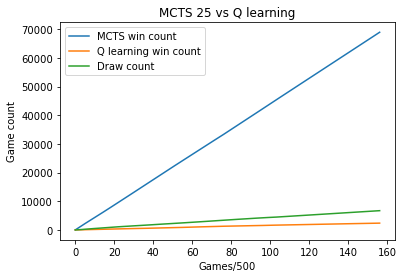

In [56]:
import matplotlib.pyplot as plt
plt.title("MCTS 25 vs Q learning")
plt.xlabel("Games/500")
plt.ylabel("Game count")
plt.plot(game_count_list, mcts_win_count, label = "MCTS win count")
plt.plot(game_count_list,q_learning_win_count, label = "Q learning win count")
plt.plot(game_count_list,draw_count, label = "Draw count")
plt.legend()
plt.show()

In [51]:
new_q=[]
new_m=[]
new_d=[]
for i in range (1,len(game_count_list)):
    new_q.append(q_learning_win_count[i]-q_learning_win_count[i-1])
    new_m.append(mcts_win_count[i]-mcts_win_count[i-1])
    new_d.append(draw_count[i]-draw_count[i-1])

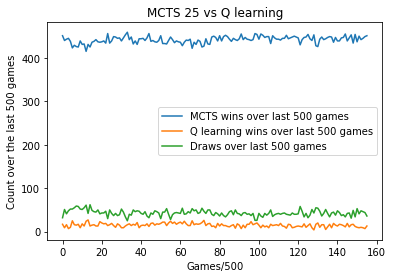

In [58]:
plt.title("MCTS 25 vs Q learning")
plt.xlabel("Games/500")
plt.ylabel("Count over the last 500 games")
plt.plot(game_count_list[:-1], new_m, label = "MCTS wins over last 500 games" )
plt.plot(game_count_list[:-1], new_q, label = "Q learning wins over last 500 games")
plt.plot(game_count_list[:-1], new_d, label = "Draws over last 500 games")
plt.legend()
plt.show()

In [128]:
temp_dict ={}
try:
    q_file = open('q_vals.dat', 'rb')
    temp_dict=pkl.load(q_file)
    q_file.close()
except Exception as e:
    print(e)
    
print (len(temp_dict))

89013


In [127]:
print (len(qLearningObj.q_values))

89013


# Test cells

In [126]:
try:
    q_file = open('q_vals.dat', 'wb')
    pkl.dump(qLearningObj.q_values, q_file)
    q_file.close()
except Exception as e:
    print(e)

In [87]:
qLearningObj = QLearning()

In [88]:
temp = np.array([[-1, -1 , 0, 1, 1],
                [-1, 1, -1, -1, 1],
                [1, 1, -1,1, -1],
                [-1,-1,-1,1,1]])

In [94]:
qls,_=qLearningObj.perform_action(temp,epsilon =2)
qls

Current state: [[-1 -1  0  1  1]
 [-1  1 -1 -1  1]
 [ 1  1 -1  1 -1]
 [-1 -1 -1  1  1]]
State action values: 0 -inf
State action values: 1 -inf
State action values: 2 -0.2762446045160035
index: 2
State action values: 3 -inf
State action values: 4 -inf


array([[-1, -1,  1,  1,  1],
       [-1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1],
       [-1, -1, -1,  1,  1]])

In [521]:
#player0 is -1 for player param in search 
root_state = np.zeros((row,col), dtype=int)
root_node = Node(1, root_state, None)
mctsObj = MonteCarloTreeSearch()
new_state = mctsObj.search(root_node)

Visited count for rootNode: 200
Visited count for the selected node: 76
Visited counts for all children:
76
13
31
55
25


In [522]:
print (new_state.state)

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [-1  0  0  0  0]]


In [ ]:
np.array([[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 1.  0.  0. -1.  0.]
 [ 1.  0.  1. -1.  0.]])

In [290]:
game_result(temp.state)

-1

In [529]:
test=[1.0,inf,2.45,3,inf]

In [546]:
curr_time=time.time_ns()
np.argmax(test)
time.time_ns()-curr_time

0

In [549]:

curr_time=time.time_ns()
test.index(max(test))
time.time_ns()-curr_time

0

In [558]:
curr_time=time.time_ns()
np.log(123.41)
new_time=time.time_ns()
new_time-curr_time

0

In [554]:
curr_time=time.time_ns()
log(123.41)
time.time_ns()-curr_time

0